# Introduction

How much does what is included in the annotation set matter?

In [1]:
import seaborn
import scipy
import anndata
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot, cm
import sys
import pysam
from collections import Counter
from IPython import display

import upsetplot

In [2]:
pandas.options.display.max_rows = 300

In [3]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/ENCSR724KET_16f_nuc'

In [4]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [5]:
v29_genome_dir = Path("~/proj/genome/").expanduser()
v29_store = pandas.HDFStore(v29_genome_dir / "GRCh38-V29-male" / "GRCh38-V29-male.h5")
v29_gtf = v29_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v29_store.close()

v29_gene_base_to_id = {}
v29_gene_id_to_name = {}
v29_gene_id_to_type = {}
for i, row in v29_gtf.iterrows():
    v29_gene_base_to_id[row.gene_id.split('.')[0]] = row.gene_id
    v29_gene_id_to_name[row.gene_id] = row.gene_name
    v29_gene_id_to_type[row.gene_id] = row.gene_type

def calculate_v29_gene_base(gene_id):
    gene_base = gene_id.split('.')[0]
    if gene_id.endswith("_PAR_Y"):
        gene_base += "_PAR_Y"
    return gene_base
v29_gtf['gene_base'] = v29_gtf['gene_id'].apply(calculate_v29_gene_base)

In [6]:
v32m_genome_dir = Path("~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/").expanduser()
v32m_store = pandas.HDFStore(v32m_genome_dir / "GRCh38-arc2.0-2.7.8a" / "GRCh38-arc2.0-2.7.8a.h5")
v32m_gtf = v32m_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v32m_store.close()

v32m_gtf.columns = ['gene_base', 'gene_name', 'gene_type']
v32m_gtf['gene_id'] = v32m_gtf['gene_base'].apply(lambda x: v29_gene_base_to_id.get(x, x))

v32m_gene_id_to_name = {}
v32m_gene_id_to_type = {}
for i, row in v32m_gtf.iterrows():
    v32m_gene_id_to_name[row.gene_id] = row.gene_name
    v32m_gene_id_to_type[row.gene_id] = row.gene_type

In [7]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered", multiread="Unique"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "GeneFull_Ex50pAS", "SJ"]
    MULTIREAD_MATRIX = {
    "Unique": "matrix.mtx",
    "Rescue": "UniqueAndMult-Rescue.mtx",
    "EM": "UniqueAndMult-EM.mtx",
    }
    assert multiread in MULTIREAD_MATRIX

    analysis_dir = Path(analysis_dir)
    
    solo_dir = analysis_dir / "Solo.out" / quantification 
    solo = scanpy.read_mtx(solo_dir / "raw" / MULTIREAD_MATRIX[multiread]).T
    solo_vars = pandas.read_csv(
        solo_dir / "raw" / "features.tsv", header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "raw" / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]
    
    if mode == "filtered":
        solo_obs = pandas.read_csv(
            solo_dir / mode / "barcodes.tsv", header=None, sep="\t"
        ).values.T[0]
        solo = solo[solo_obs,:]
        

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



I tried to do an analysis using the the different modes of soloMultiMappers but they seemed too similar.
Then I computed the md5sum of the matrix files... and yeah the argument didn't seem to do anything.

<table>
<tr><td>ffb6d23ee397674a310d93039e4111a7</td><td>fullsolo_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>ffb6d23ee397674a310d93039e4111a7</td><td>fullsolo_em_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>ffb6d23ee397674a310d93039e4111a7</td><td>fullsolo_rescue_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>00dd2450e656ceaffe533c4558e16227</td><td>minimalsolo_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>00dd2450e656ceaffe533c4558e16227</td><td>minimalsolo_em_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>00dd2450e656ceaffe533c4558e16227</td><td>minimalsolo_rescue_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
</table>

I also learned that there's some gene base ids that have two version varients. (One example)
<table>
<tr><td>gene_id 	</td><td>gene_name 	</td><td>gene_type</td></tr>
<tr><td>ENSG00000169084.13 	</td><td>DHRSX 	</td><td>protein_coding</td></tr>
    <tr><td>ENSG00000169084.13_PAR_Y 	</td><td>DHRSX 	</td><td>protein_coding</td></tr>
</table>

# Load Datasets

In [8]:
algorithm_roots = {
    'tenx solo uniq': (Path("tenxsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Unique"),
    'tenx solo rescue': (Path("tenxsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Rescue"),
    'tenx solo em': (Path("tenxsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "EM"),
    
    'encode full solo uniq': (Path("fullsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Unique"),
    'encode full solo rescue': (Path("fullsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Rescue"),
    'encode full solo em': (Path("fullsolo_multi_2.7.9a_2021-06-25"),  "GeneFull", "filtered", "EM"),

    'encode minimal solo uniq': (Path("minimalsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Unique"),
    'encode minimal solo rescue': (Path("minimalsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "Rescue"),
    'encode minimal solo em': (Path("minimalsolo_multi_2.7.9a_2021-06-25"), "GeneFull", "filtered", "EM"),
}

In [9]:
algorithm_filtered = {}
for algorithm in algorithm_roots:
    root, quantification, filtering, multiread = algorithm_roots[algorithm]
    print("loading {}".format(algorithm))
    algorithm_filtered[algorithm] = scanpy_load_solo278a_mtx(root, quantification, filtering, multiread)
    print(algorithm, algorithm_filtered[algorithm].shape, algorithm_filtered[algorithm].X.sum())

loading tenx solo uniq


Trying to set attribute `.obs` of view, copying.


tenx solo uniq (15812, 36601) 84269840.0
loading tenx solo rescue


Trying to set attribute `.obs` of view, copying.


tenx solo rescue (15812, 36601) 89073760.0
loading tenx solo em


Trying to set attribute `.obs` of view, copying.


tenx solo em (15812, 36601) 89073760.0
loading encode full solo uniq


Trying to set attribute `.obs` of view, copying.


encode full solo uniq (15605, 59526) 80314560.0
loading encode full solo rescue


Trying to set attribute `.obs` of view, copying.


encode full solo rescue (15605, 59526) 89503700.0
loading encode full solo em


Trying to set attribute `.obs` of view, copying.


encode full solo em (15605, 59526) 89503690.0
loading encode minimal solo uniq


Trying to set attribute `.obs` of view, copying.


encode minimal solo uniq (15650, 28249) 78668630.0
loading encode minimal solo rescue


Trying to set attribute `.obs` of view, copying.


encode minimal solo rescue (15650, 28249) 85005160.0
loading encode minimal solo em


Trying to set attribute `.obs` of view, copying.


encode minimal solo em (15650, 28249) 85005160.0


# Add (faked) version to 10x annotation

The 10x provided annotation GTF file, based on GENCODE V32, has the gene version number removed, to make later comparisons easier I added the gene version number from my V29 GTF on to the V32 gene base ids.

(Gene base = ENSG00000243485)

(Gene id with version = ENSG00000243485.5)

In [10]:
algorithm_filtered['tenx solo uniq'].var_names[:5]

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945'],
      dtype='object')

In [11]:
for algorithm in algorithm_filtered:
    if algorithm.startswith("tenx"):
        algorithm_filtered[algorithm].var_names = v32m_gtf.set_index('gene_base').reindex(algorithm_filtered[algorithm].var_names.to_list())['gene_id']

In [12]:
algorithm_filtered['tenx solo uniq'].var_names[:5]

Index(['ENSG00000243485.5', 'ENSG00000237613.2', 'ENSG00000186092.6',
       'ENSG00000238009.6', 'ENSG00000239945.1'],
      dtype='object', name='gene_id')

# Remove version from ENCODE annotations

In [13]:
#algorithm_filtered['encode minimal solo uniq'].var_names

In [14]:
#for algorithm in algorithm_filtered:
#    if algorithm != 'tenx solo uniq':
#        algorithm_filtered[algorithm].var_names = [x.split('.')[0] for x in algorithm_filtered[algorithm].var_names]


In [15]:
#algorithm_filtered['encode minimal solo uniq'].var_names

# Cell barcodes in common

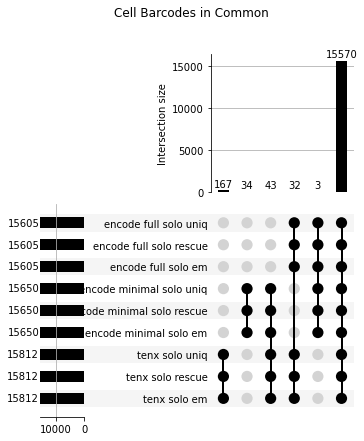

In [16]:
algorithm_cell_barcodes = {}
for algorithm in algorithm_filtered:
    algorithm_cell_barcodes[algorithm] = algorithm_filtered[algorithm].obs_names

common_cell_barcode_set = upsetplot.from_contents(algorithm_cell_barcodes)
f = pyplot.figure()
f.suptitle("Cell Barcodes in Common")
_ = upsetplot.plot(common_cell_barcode_set, fig=f, show_counts=True)


# Gene IDs in common

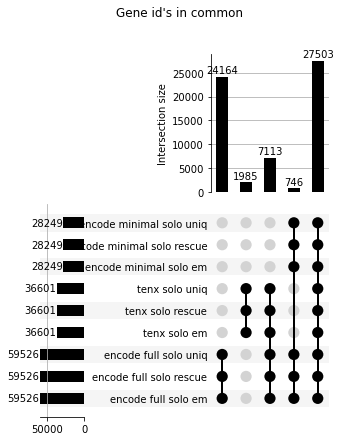

In [17]:
algorithm_gene_base_ids = {}
for algorithm in algorithm_filtered:
    algorithm_gene_base_ids[algorithm] = set(algorithm_filtered[algorithm].var_names)

common_gene_base_contents = upsetplot.from_contents(algorithm_gene_base_ids)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
f = pyplot.figure()
f.suptitle("Gene id's in common")
_ = upsetplot.plot(common_gene_base_contents, fig=f, show_counts=True)

# What are some of those genes in tenx & encode full 

In [18]:
common_gene_base_contents

id
tenx solo uniq tenx solo rescue tenx solo em encode full solo uniq encode full solo rescue encode full solo em encode minimal solo uniq encode minimal solo rescue encode minimal solo em                    
True           True             True         True                  True                    True                True                     True                       True                     ENSG00000274367.1
                                                                                                               False                    False                      False                    ENSG00000233338.1
                                                                                                               True                     True                       True                    ENSG00000092330.16
                                                                                                                                                                   True                     ENSG00000228208.6
                                                                                                                                                                   True                     ENSG00000231492.2
...                                                                                                                                                                                                       ...
False          False            False        True                  True                    True                False                    False                      False                    ENSG00000241120.1
                                                                                                                                                                   False                    ENSG00000223948.1
                                                                                                                                                                   False                    ENSG00000261778.1
                                                                                                                                                                   False                    ENSG00000252677.1
                                                                                                                                                                   False                    ENSG00000200613.1

[61511 rows x 1 columns]

In [19]:
not_in_encode_minimal = common_gene_base_contents.loc[True,True,True,True,True,True,False,False,False]['id'].values

changed_between_versions = []
for gene_base in not_in_encode_minimal:
    changed_between_versions.append({
        'gene_base': gene_base,
        'v29_type': v29_gene_id_to_type[gene_base],
        'v32_type': v32m_gene_id_to_type[gene_base],
    })
    
changed_between_versions = pandas.DataFrame(changed_between_versions)

<ipython-input-19-f9b6b4ac231c>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  not_in_encode_minimal = common_gene_base_contents.loc[True,True,True,True,True,True,False,False,False]['id'].values


In [20]:
changed_between_versions[changed_between_versions['v29_type'] != changed_between_versions['v32_type']]

gene_base           v29_type v32_type
0     ENSG00000233338.1          antisense   lncRNA
1     ENSG00000263220.1          antisense   lncRNA
2     ENSG00000251179.1          antisense   lncRNA
3     ENSG00000262434.1          antisense   lncRNA
4     ENSG00000260441.5          antisense   lncRNA
...                 ...                ...      ...
7108  ENSG00000267429.1     sense_intronic   lncRNA
7109  ENSG00000268618.1          antisense   lncRNA
7110  ENSG00000275417.1     sense_intronic   lncRNA
7111  ENSG00000255092.1          antisense   lncRNA
7112  ENSG00000260190.1  sense_overlapping   lncRNA

[7113 rows x 3 columns]

In [21]:
changed_between_versions[changed_between_versions['v29_type'] != changed_between_versions['v32_type']]['v32_type'].unique()

array(['lncRNA', 'protein_coding'], dtype=object)

# Build list of cells and gene ids in common between all runs

In [22]:
common_cell_barcode_set = None
for algorithm in algorithm_filtered:
    if common_cell_barcode_set is None:
        common_cell_barcode_set = set(algorithm_filtered[algorithm].obs_names)
    else:
        common_cell_barcode_set = common_cell_barcode_set.intersection(algorithm_filtered[algorithm].obs_names)

print('common_cell_barcode_set', len(common_cell_barcode_set))
common_cell_barcodes = [x for x in algorithm_filtered['encode full solo uniq'].obs_names if x in common_cell_barcode_set]
print('common_cell_barcodes', len(common_cell_barcodes))


common_cell_barcode_set 15570
common_cell_barcodes 15570


In [23]:
common_gene_id_set = None
for algorithm in algorithm_filtered:
    #if algorithm == 'tenx solo uniq':
    #    continue
    if common_gene_id_set is None:
        common_gene_id_set = set(algorithm_filtered[algorithm].var_names)
    else:
        common_gene_id_set = common_gene_id_set.intersection(algorithm_filtered[algorithm].var_names)

print("common_gene_id_set", len(common_gene_id_set), len(set(common_gene_id_set)))
common_gene_ids = [x for x in algorithm_filtered['encode full solo uniq'].var_names if x in common_gene_id_set]
print("common_gene_ids", len(common_gene_ids), len(set(common_gene_ids)))

common_gene_id_set 27503 27503
common_gene_ids 27503 27503


In [24]:
#tenx_gene_base = set(algorithm_filtered['tenx solo uniq'].var_names)
#v29_common_gene_base = [x.split('.')[0] for x in algorithm_filtered['encode full solo uniq'].var_names if x.split('.')[0] in tenx_gene_base and x in common_gene_ids]
#v29_common_gene_ids = [x for x in algorithm_filtered['encode full solo uniq'].var_names if x.split('.')[0] in tenx_gene_base and x in common_gene_ids]
#print(len(v29_common_gene_base), v29_common_gene_base[:5])

In [25]:
algorithm_common = {}
for algorithm in algorithm_filtered:
    algorithm_common[algorithm] = algorithm_filtered[algorithm][common_cell_barcodes, common_gene_ids]
    print(algorithm, algorithm_common[algorithm].shape, algorithm_common[algorithm].X.sum())

tenx solo uniq (15570, 27503) 80361560.0
tenx solo rescue (15570, 27503) 84700940.0
tenx solo em (15570, 27503) 84798720.0
encode full solo uniq (15570, 27503) 75835520.0
encode full solo rescue (15570, 27503) 81901096.0
encode full solo em (15570, 27503) 82050900.0
encode minimal solo uniq (15570, 27503) 78260490.0
encode minimal solo rescue (15570, 27503) 83137090.0
encode minimal solo em (15570, 27503) 82997820.0


# Compute correlations of cells in common between all methods

In [26]:
def compute_spearman_anndata(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    if isinstance(left, anndata._core.anndata.AnnData):
        left = left.to_df().T
    if isinstance(right, anndata._core.anndata.AnnData):
        right = right.to_df().T

    #print(left.shape[0])
    #print(left[0].shape)
    #print(right[0].shape)
    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors


def compute_correlations(table):
    programs = list(table.keys())
    correlations = {}
    dense = {}
    for name_x in programs:
        dense[name_x] = table[name_x].to_df().T

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            print("Processing {} {}".format(name_x, name_y))
            cs_cors = compute_spearman_anndata(dense[name_x], dense[name_y])
            correlations.setdefault(name_x, {})[name_y] = cs_cors
    return correlations

algorithm_correlations = compute_correlations(algorithm_common)

Processing tenx solo uniq tenx solo uniq
Processing tenx solo uniq tenx solo rescue
Processing tenx solo uniq tenx solo em
Processing tenx solo uniq encode full solo uniq
Processing tenx solo uniq encode full solo rescue
Processing tenx solo uniq encode full solo em
Processing tenx solo uniq encode minimal solo uniq
Processing tenx solo uniq encode minimal solo rescue
Processing tenx solo uniq encode minimal solo em
Processing tenx solo rescue tenx solo rescue
Processing tenx solo rescue tenx solo em
Processing tenx solo rescue encode full solo uniq
Processing tenx solo rescue encode full solo rescue
Processing tenx solo rescue encode full solo em
Processing tenx solo rescue encode minimal solo uniq
Processing tenx solo rescue encode minimal solo rescue
Processing tenx solo rescue encode minimal solo em
Processing tenx solo em tenx solo em
Processing tenx solo em encode full solo uniq
Processing tenx solo em encode full solo rescue
Processing tenx solo em encode full solo em
Processing

In [27]:
def plot_cell_correlation_histogram(table, title=None, bins=50, programs=None):
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)
    if title is not None:
        f.suptitle(title.format(metric=metric))

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            spearman = numpy.array(table[name_x][name_y])
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCount {count}', xy=(0.1, 0.6), xycoords='axes fraction')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    #f.tight_layout()
    

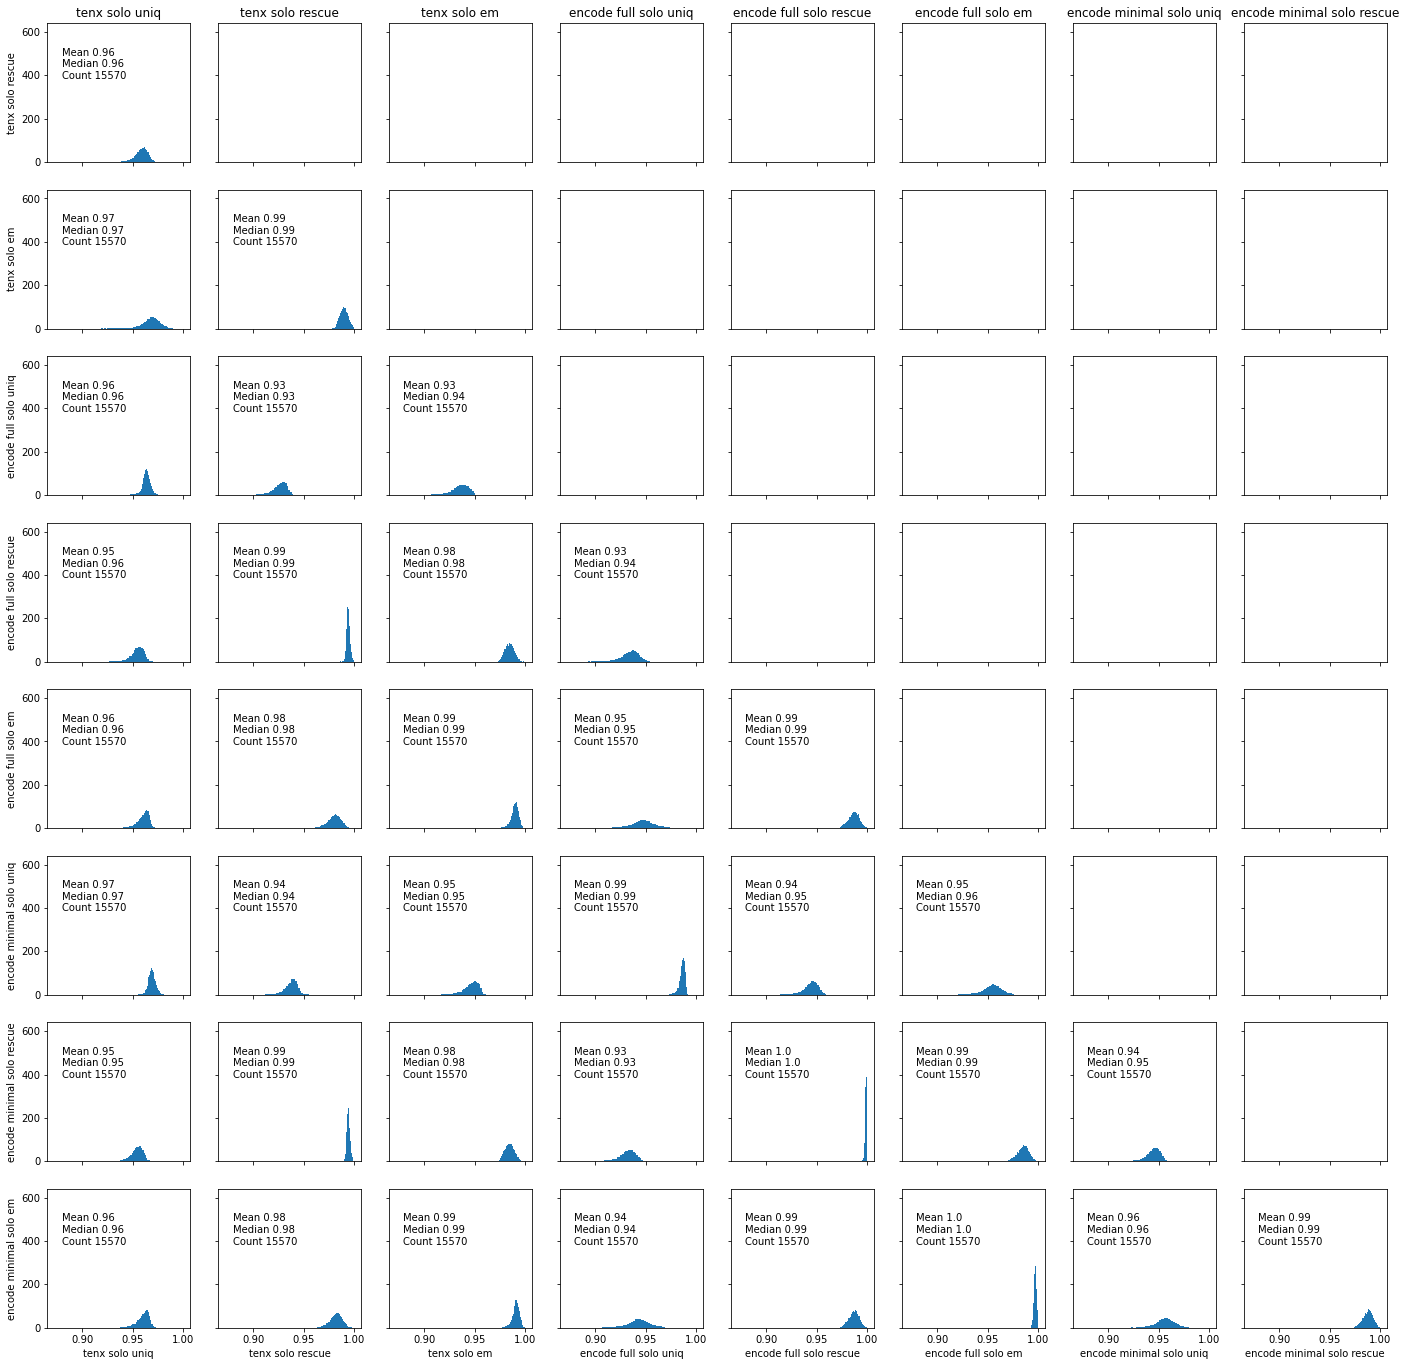

In [28]:
plot_cell_correlation_histogram(algorithm_correlations)

# Scatter plot of method genes in common over all cells

In [29]:
def plot_algorithm_sums(table, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)    
    if title is not None:
        f.suptitle(title.format(metric=metric))

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            scatter.setdefault(name_x, {})[name_y] = ax.scatter(
                numpy.asarray(table[name_x].X.sum(axis=1).T)[0], 
                numpy.asarray(table[name_y].X.sum(axis=1).T)[0],
                s=0.5
            )
            ax.set_xscale('log')
            ax.set_yscale('log')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("per algorithm sum of genes over all cells")
    #f.tight_layout()
    

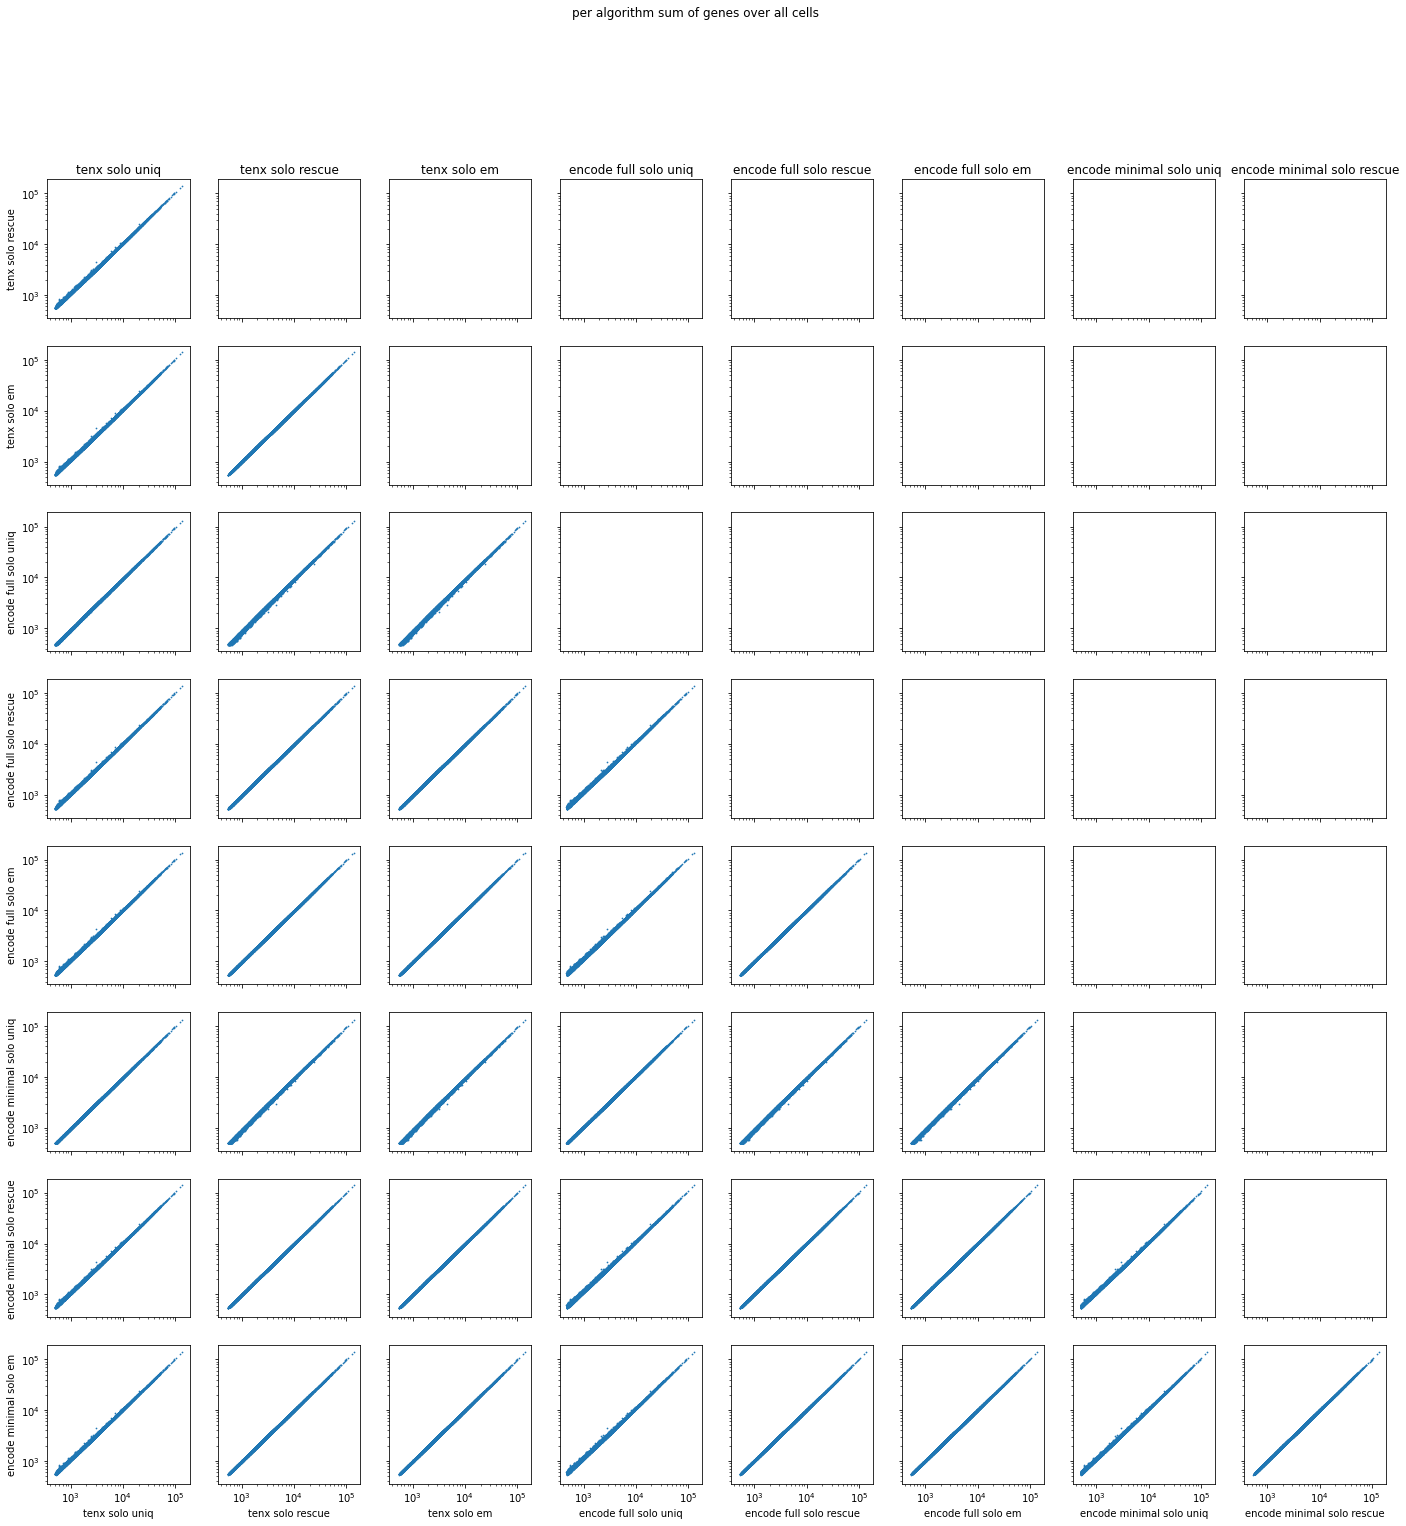

In [30]:
plot_algorithm_sums(algorithm_common)

# Scatter plots of gene expression for worst, median, and best correlated cells

In [31]:
algorithm_dense = {}
for algorithm in algorithm_common:
    algorithm_dense[algorithm] = algorithm_common[algorithm].to_df().T


In [32]:
def sc_scatter(table, correlations, name_x, name_y, cell_id, ax=None):
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in table[name_x].index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    ax.scatter(numpy.log2(table[name_x][cell_id]+0.01), numpy.log2(table[name_y][cell_id]+0.01), color=colors, s=2)
    spearman = correlations[name_x][name_y][cell_id]
    expressed_in_x = table[name_x][cell_id] > 0
    expressed_in_y = table[name_y][cell_id] > 0
    count = table[name_x][expressed_in_x & expressed_in_y].shape[0]
    ax.set_title(f'id {cell_id}\nSpearman {spearman:0.4}\nCount: {count}')
    ax.set_xlabel(name_x)
    ax.set_ylabel(name_y)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)

def show_scatter_extremes(dense_mat, correlations, name_x, name_y):
    scores = correlations[name_x][name_y]
    best_cell = scores.idxmax()
    worst_cell = scores.idxmin()
    # find smallest absolute difference from median and use that as median cell
    median = numpy.abs(scores - scores.median())
    median_cell = median.idxmin()
    
    f = pyplot.figure(figsize=(12,4))
    #f.suptitle(f'{metric} worst, median and best cells')
    axes = f.subplots(1,3, sharex=True, sharey=True)
    sc_scatter(dense_mat, correlations, name_x, name_y, worst_cell, ax=axes[0])
    sc_scatter(dense_mat, correlations, name_x, name_y, median_cell, ax=axes[1])
    sc_scatter(dense_mat, correlations, name_x, name_y, best_cell, ax=axes[2])
    return f

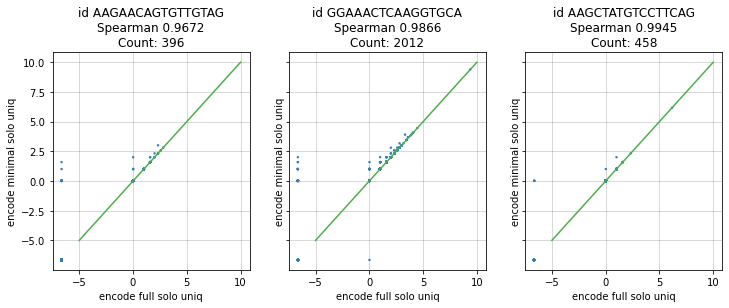

In [33]:
f = show_scatter_extremes(algorithm_dense, algorithm_correlations,'encode full solo uniq', 'encode minimal solo uniq')

<ipython-input-32-408e00a00fee>:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = pyplot.figure(figsize=(12,4))


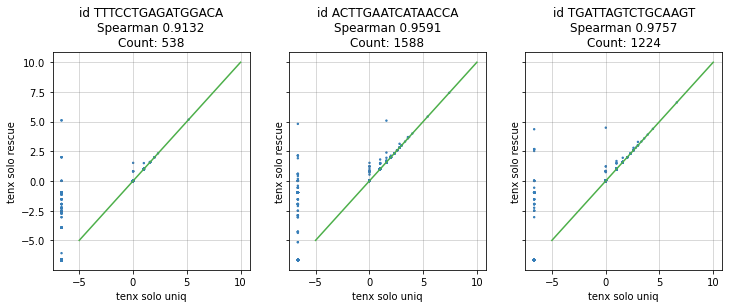

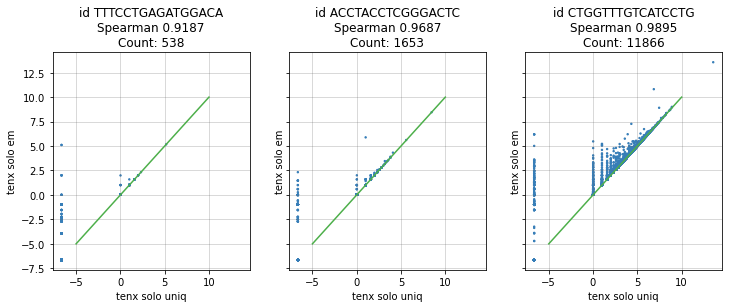

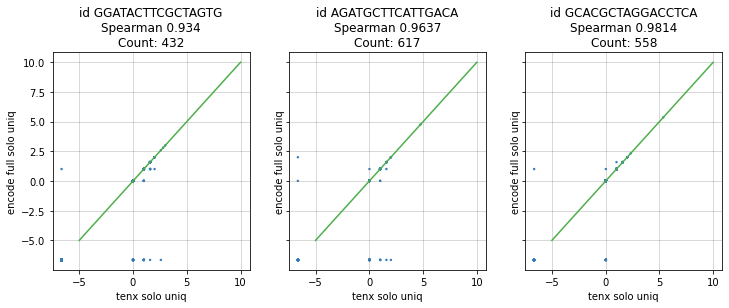

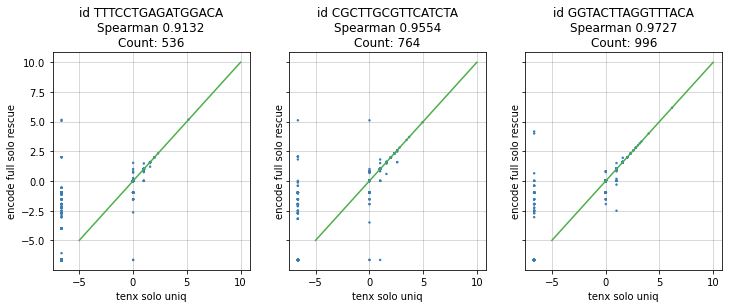

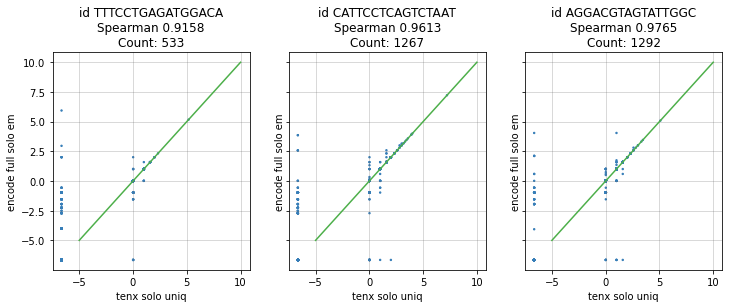

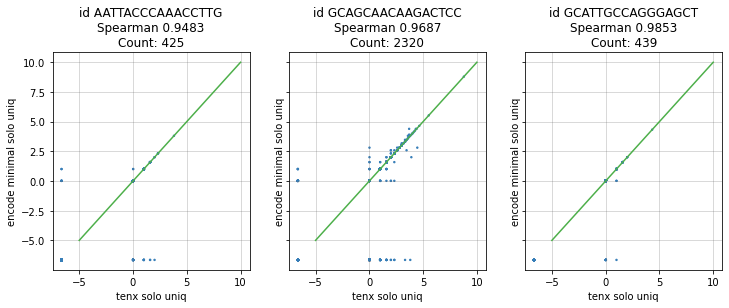

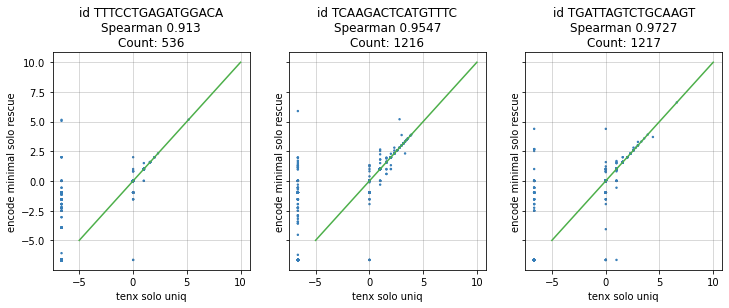

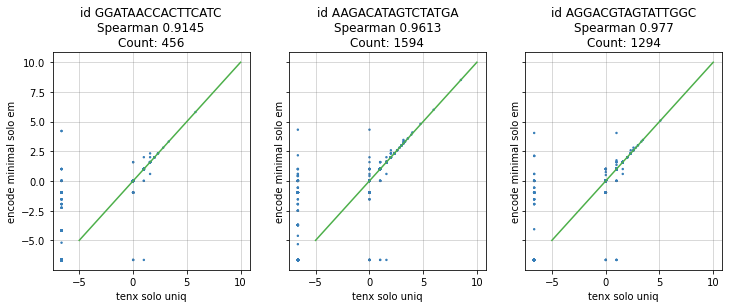

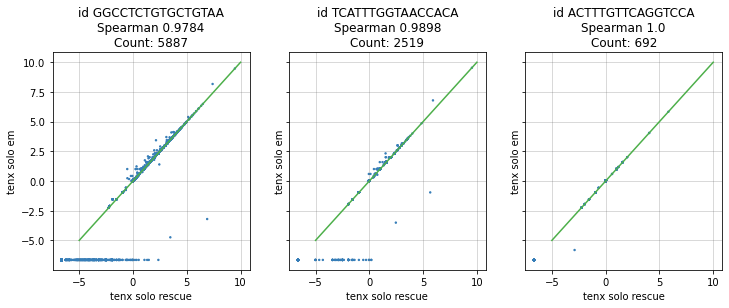

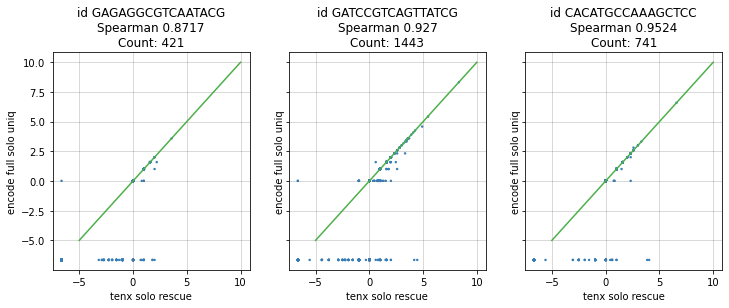

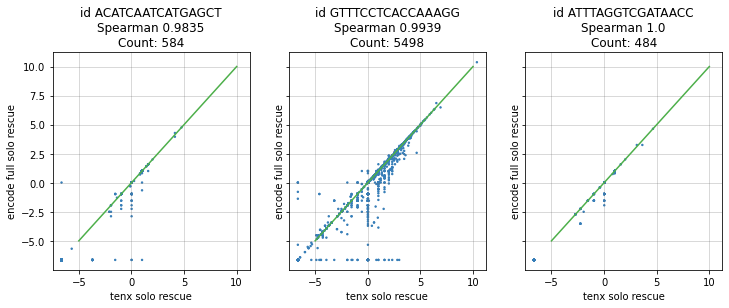

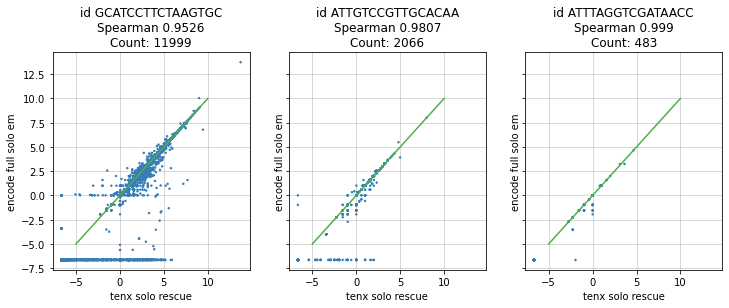

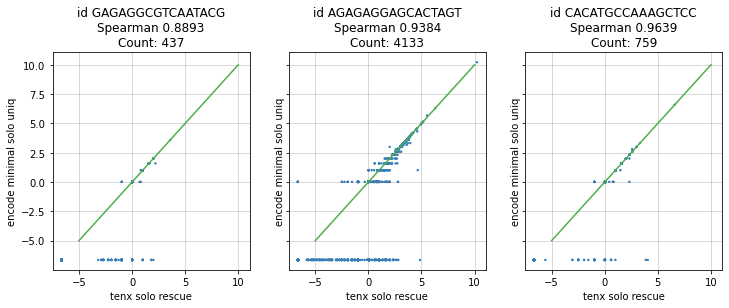

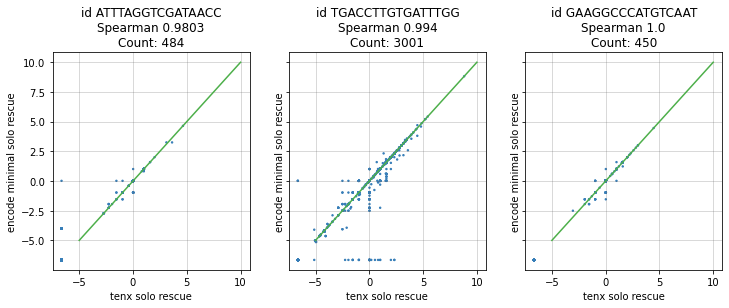

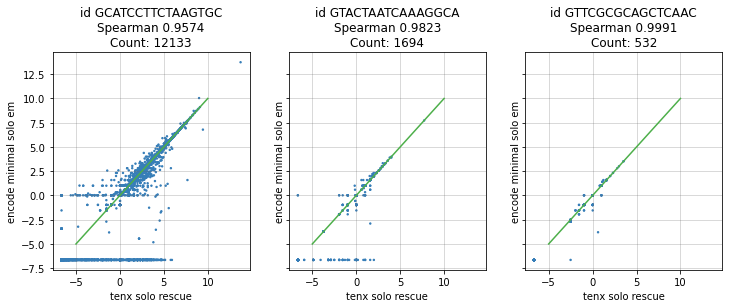

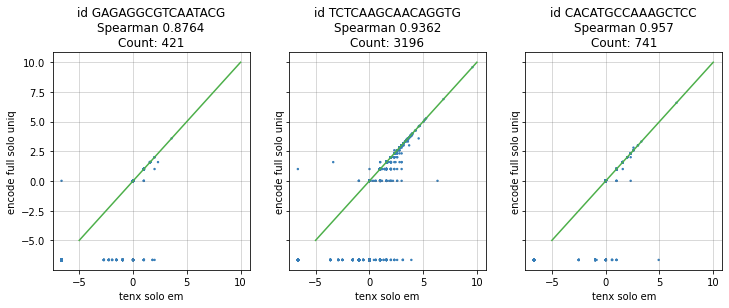

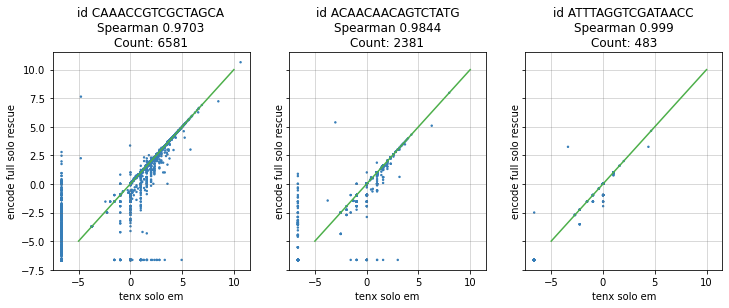

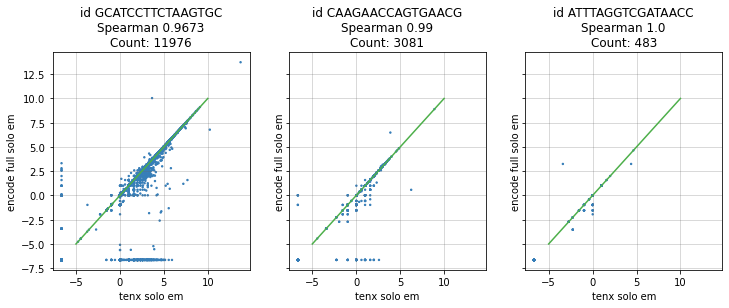

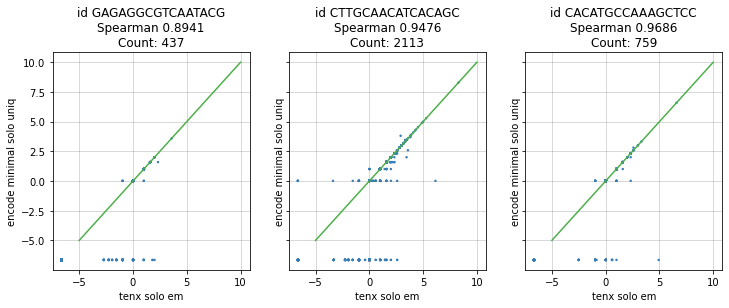

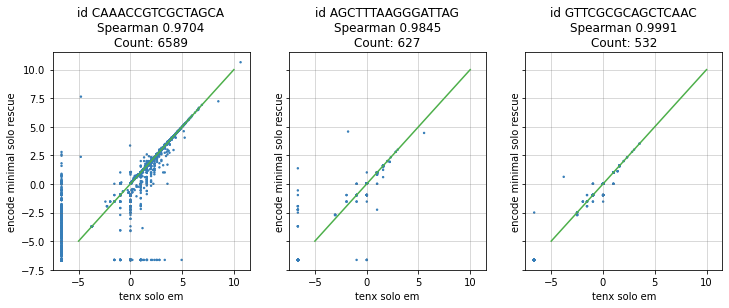

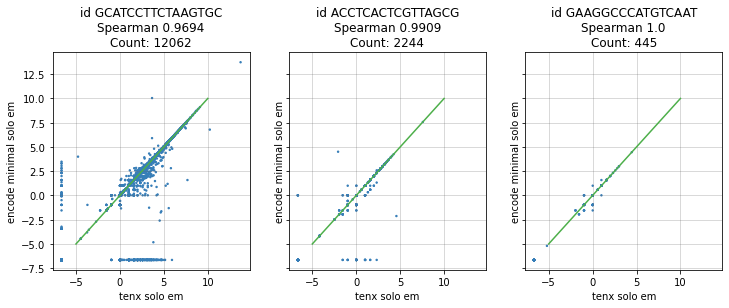

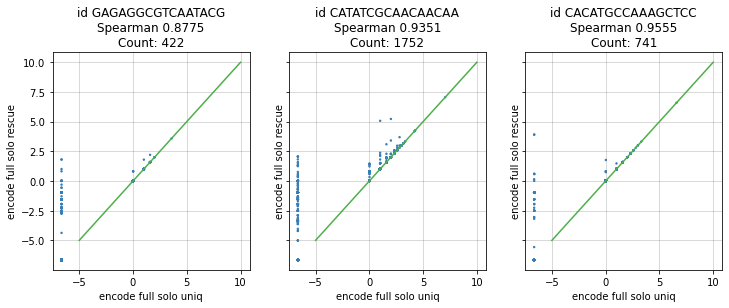

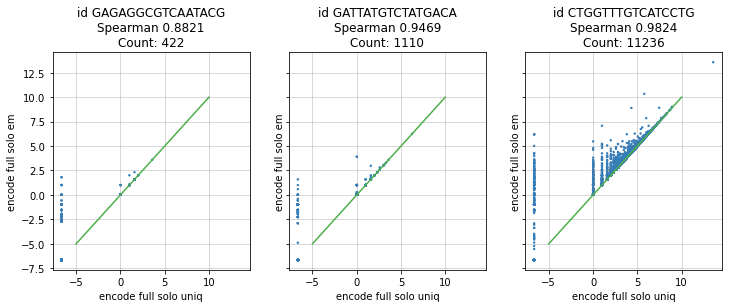

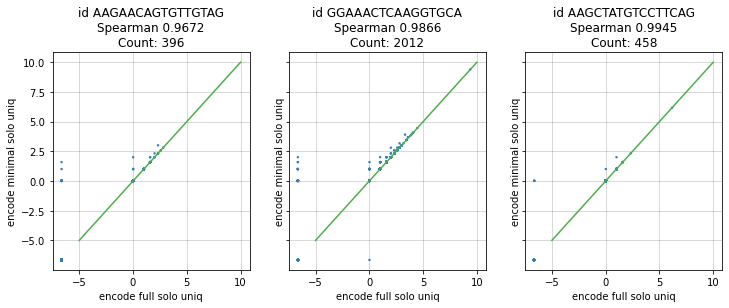

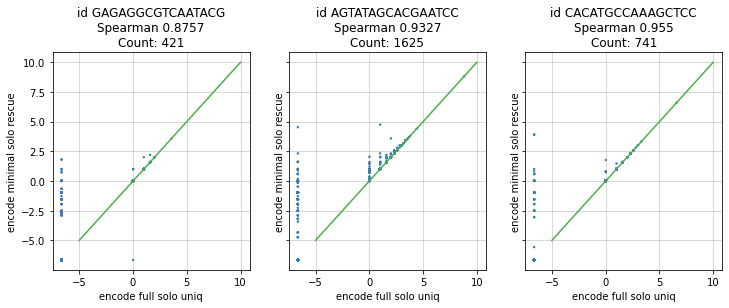

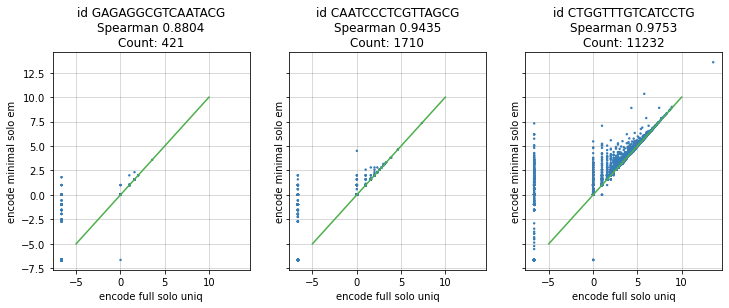

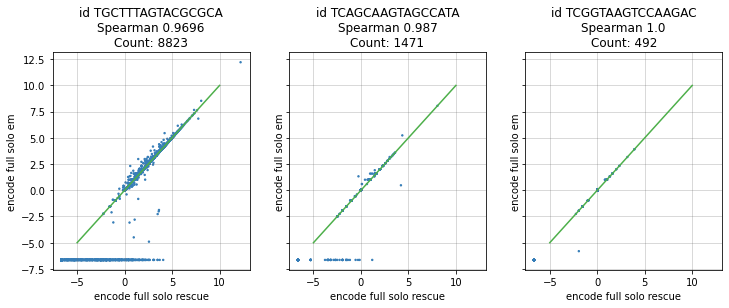

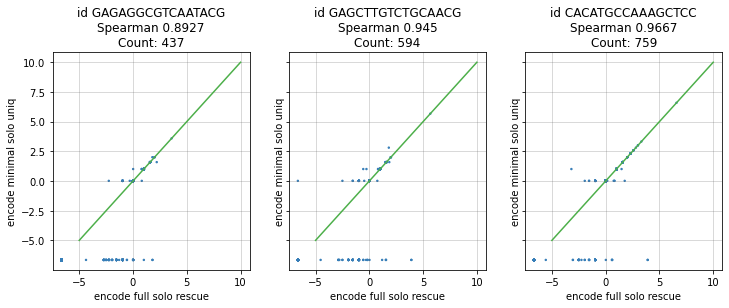

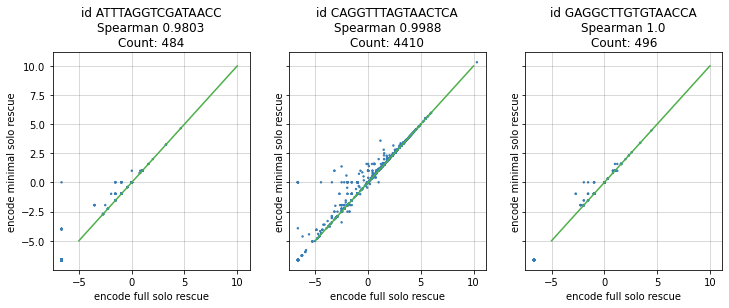

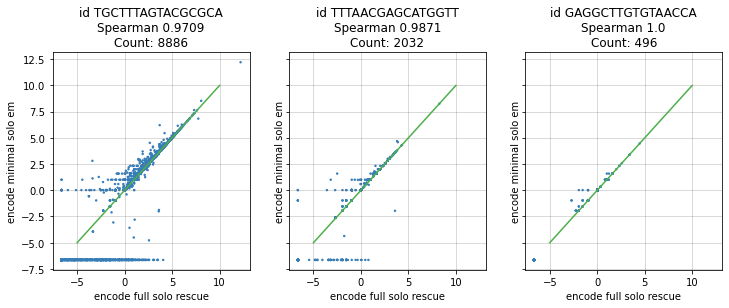

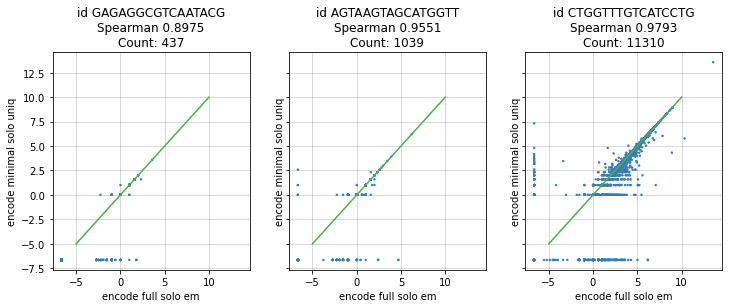

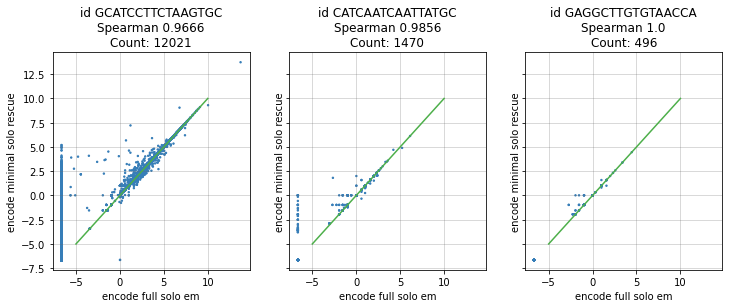

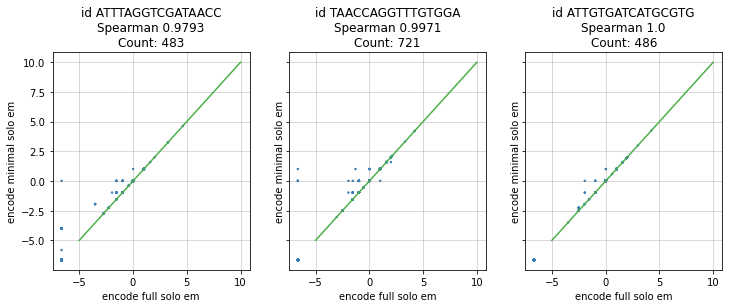

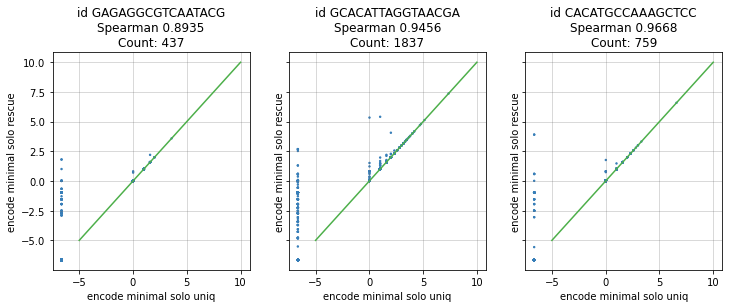

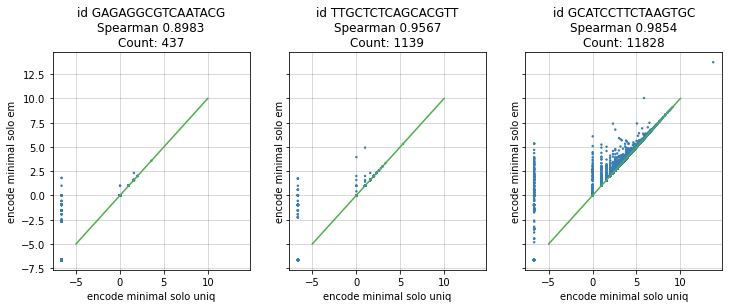

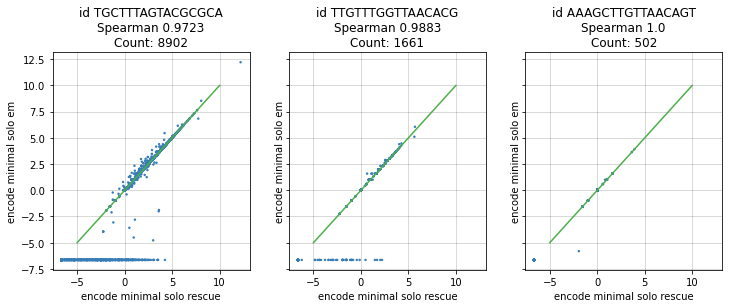

In [34]:
def plot_all_scatter_extremes(table, correlations):
    programs = list(table.keys())


    for name_x in programs:
        for name_y in programs[programs.index(name_x)+1:]:
            #print("Comparing {} {}".format(name_x, name_y))
            f = show_scatter_extremes(table, correlations, name_x, name_y)
            
            
plot_all_scatter_extremes(algorithm_dense, algorithm_correlations)

# Scatter plot of cells with the highest expression sum

In [35]:
def plot_algorithm_most_expressed(table, correlations, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)
    if title is not None:
        f.suptitle(title.format(metric=metric))


    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            max_cell = algorithm_dense[name_x].sum(axis=0).idxmax()
            scatter.setdefault(name_x, {})[name_y] = sc_scatter(table, correlations, name_x, name_y, max_cell, ax=ax)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Compare algorithms with cell with highest expression sum")
    #f.tight_layout()
    

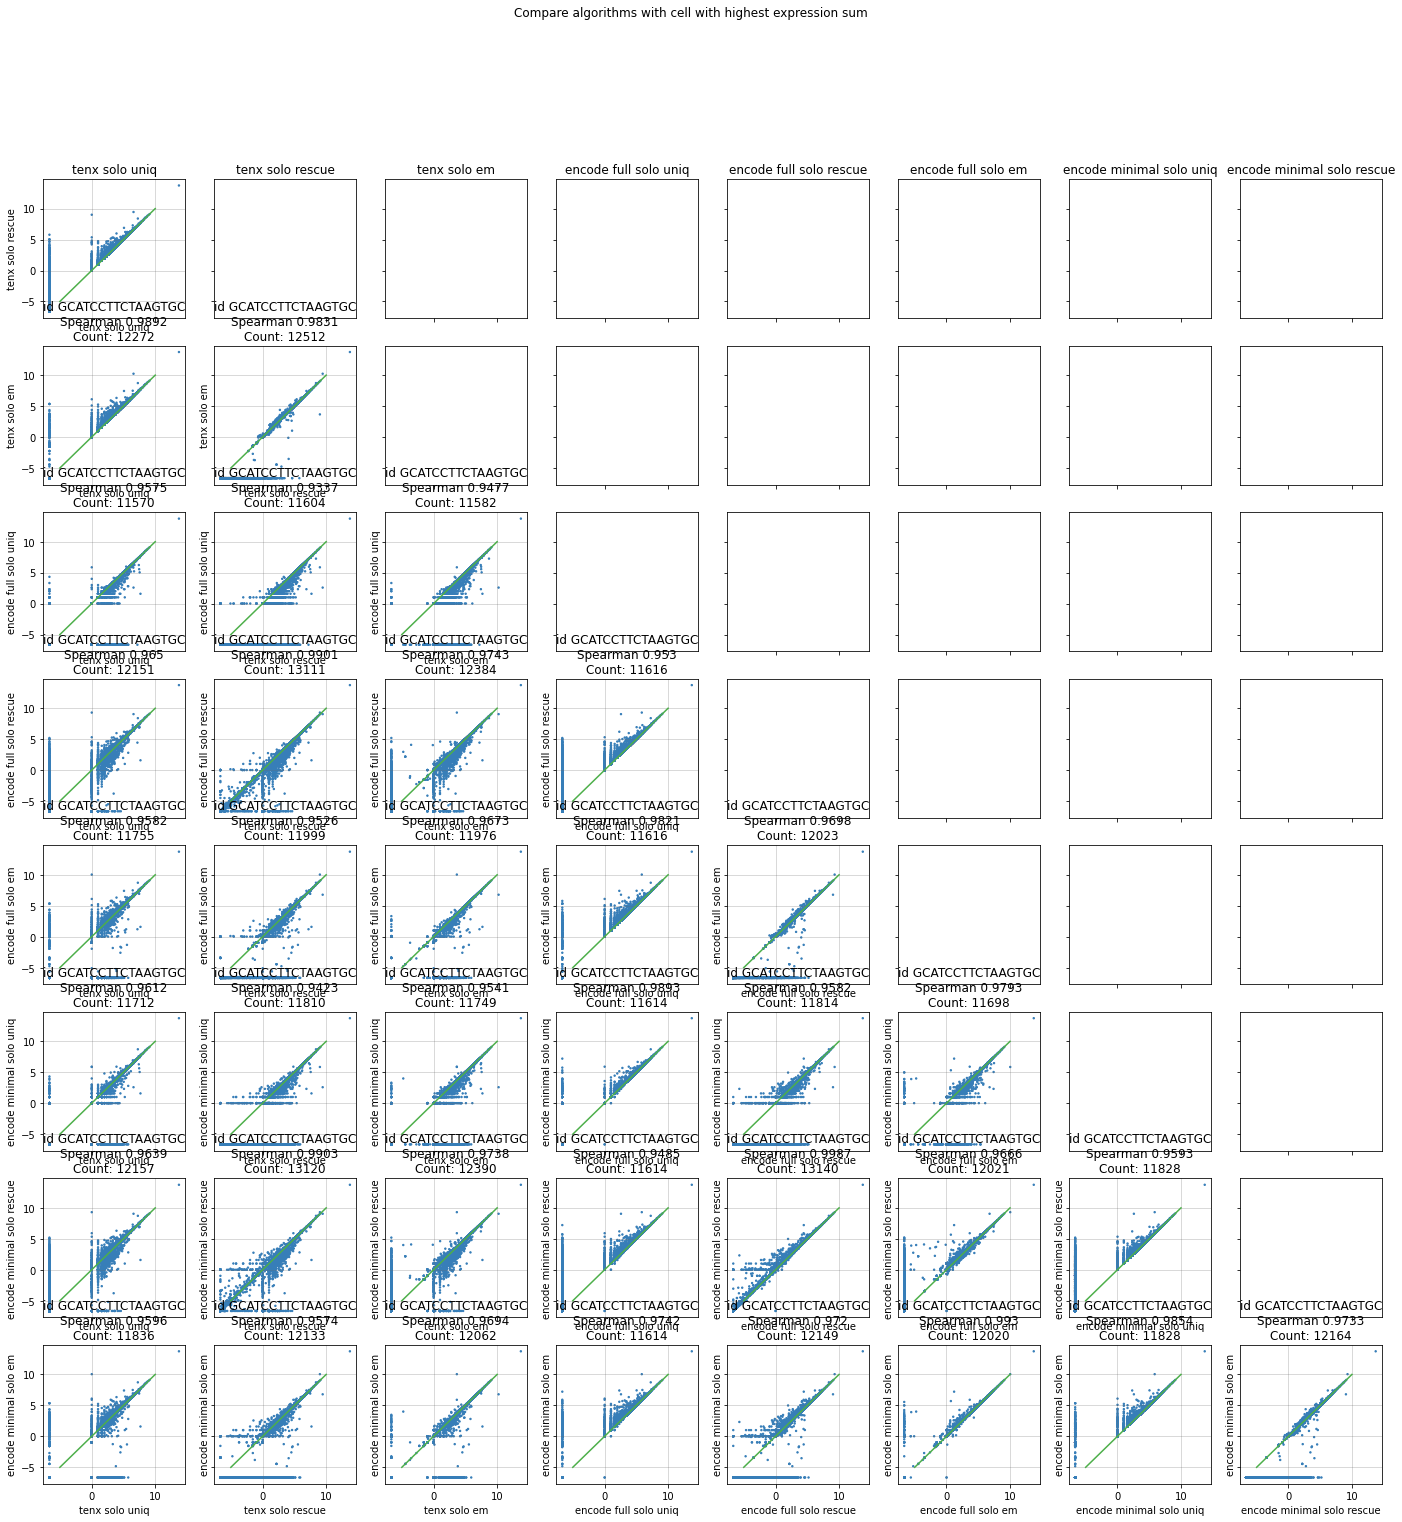

In [36]:
plot_algorithm_most_expressed(algorithm_dense, algorithm_correlations)

It seems weird that there's expression in encode minimal, but not in encode full, maybe I have the labels backward?

In [37]:
encode_minimal_uniq_sum = algorithm_dense['encode minimal solo uniq'].sum(axis=1)
encode_full_uniq_sum = algorithm_dense['encode full solo uniq'].sum(axis=1)

In [38]:
in_minimal_uniq_sum = encode_minimal_uniq_sum > 0
not_in_minimal_uniq_sum = encode_minimal_uniq_sum == 0
in_full_uniq_sum = encode_full_uniq_sum > 0
not_in_full_uniq_sum =(encode_full_uniq_sum == 0)

encode_minimal_uniq_sum[in_minimal_uniq_sum & not_in_full_uniq_sum]

ENSG00000225880.5       253.0
ENSG00000231510.1         1.0
ENSG00000142789.19       19.0
ENSG00000270103.3       105.0
ENSG00000214114.8       209.0
ENSG00000270457.1        15.0
ENSG00000174021.10     5852.0
ENSG00000196427.13        3.0
ENSG00000270066.3       158.0
ENSG00000235887.2         2.0
ENSG00000272824.1        10.0
ENSG00000236334.2        16.0
ENSG00000236427.1        24.0
ENSG00000173110.7       171.0
ENSG00000235736.1        17.0
ENSG00000203601.3       576.0
ENSG00000224810.1         2.0
ENSG00000243636.1        88.0
ENSG00000281664.1        23.0
ENSG00000278467.1        63.0
ENSG00000242042.1         2.0
ENSG00000153230.4         1.0
ENSG00000187701.4         1.0
ENSG00000243943.9      3220.0
ENSG00000273006.1         4.0
ENSG00000187600.14       14.0
ENSG00000284701.1         1.0
ENSG00000171150.8      5556.0
ENSG00000055813.5      1256.0
ENSG00000237651.6      2246.0
ENSG00000281920.1        45.0
ENSG00000222041.11     1970.0
ENSG00000125551.18       27.0
ENSG000002

# Quick glance at genes that are expressed in just in the minimal set

In [39]:
v29_gtf.set_index('gene_id').reindex(encode_minimal_uniq_sum[in_minimal_uniq_sum & not_in_full_uniq_sum].index)

gene_name        gene_type        gene_base
ENSG00000225880.5     LINC00115          lincRNA  ENSG00000225880
ENSG00000231510.1    AL691497.1          lincRNA  ENSG00000231510
ENSG00000142789.19       CELA3A   protein_coding  ENSG00000142789
ENSG00000270103.3    AL360012.1          lincRNA  ENSG00000270103
ENSG00000214114.8         MYCBP   protein_coding  ENSG00000214114
ENSG00000270457.1    AC093424.1          lincRNA  ENSG00000270457
ENSG00000174021.10         GNG5   protein_coding  ENSG00000174021
ENSG00000196427.13        NBPF4   protein_coding  ENSG00000196427
ENSG00000270066.3    AL356488.2          lincRNA  ENSG00000270066
ENSG00000235887.2    AC239859.3          lincRNA  ENSG00000235887
ENSG00000272824.1    AC245100.7          lincRNA  ENSG00000272824
ENSG00000236334.2       PPIAL4G   protein_coding  ENSG00000236334
ENSG00000236427.1    AL589986.2          lincRNA  ENSG00000236427
ENSG00000173110.7         HSPA6   protein_coding  ENSG00000173110
ENSG00000235736.1    AL031275.1          lincRNA  ENSG00000235736
ENSG00000203601.3     LINC00970          lincRNA  ENSG00000203601
ENSG00000224810.1    AL355482.1          lincRNA  ENSG00000224810
ENSG00000243636.1    AL445493.2          lincRNA  ENSG00000243636
ENSG00000281664.1     LINC00538          lincRNA  ENSG00000281664
ENSG00000278467.1    AC138393.3          lincRNA  ENSG00000278467
ENSG00000242042.1     LINC01743          lincRNA  ENSG00000242042
ENSG00000153230.4        OR14K1   protein_coding  ENSG00000153230
ENSG00000187701.4        OR2T27   protein_coding  ENSG00000187701
ENSG00000243943.9        ZNF512   protein_coding  ENSG00000243943
ENSG00000273006.1    AC009229.3          lincRNA  ENSG00000273006
ENSG00000187600.14    LINC02583          lincRNA  ENSG00000187600
ENSG00000284701.1       TMEM247   protein_coding  ENSG00000284701
ENSG00000171150.8         SOCS5   protein_coding  ENSG00000171150
ENSG00000055813.5       CCDC85A   protein_coding  ENSG00000055813
ENSG00000237651.6       C2orf74   protein_coding  ENSG00000237651
ENSG00000281920.1    AC007389.5          lincRNA  ENSG00000281920
ENSG00000222041.11        CYTOR          lincRNA  ENSG00000222041
ENSG00000125551.18       PLGLB2   protein_coding  ENSG00000125551
ENSG00000211592.8          IGKC        IG_C_gene  ENSG00000211592
ENSG00000211593.2         IGKJ5        IG_J_gene  ENSG00000211593
ENSG00000211594.2         IGKJ4        IG_J_gene  ENSG00000211594
ENSG00000235235.6    IGKV1OR2-1  IG_V_pseudogene  ENSG00000235235
ENSG00000198914.3        POU3F3   protein_coding  ENSG00000198914
ENSG00000228251.1    AC012442.1          lincRNA  ENSG00000228251
ENSG00000177519.3          RPRM   protein_coding  ENSG00000177519
ENSG00000285373.1     LINC02478          lincRNA  ENSG00000285373
ENSG00000271141.1    AC010680.4          lincRNA  ENSG00000271141
ENSG00000271401.1    AC010680.5          lincRNA  ENSG00000271401
ENSG00000174325.5         DIRC1   protein_coding  ENSG00000174325
ENSG00000247626.4         MARS2   protein_coding  ENSG00000247626
ENSG00000228618.1    AC012462.2          lincRNA  ENSG00000228618
ENSG00000229352.1    AC007563.1          lincRNA  ENSG00000229352
ENSG00000227021.1    AC007557.1          lincRNA  ENSG00000227021
ENSG00000231189.1    AC013448.1          lincRNA  ENSG00000231189
ENSG00000237940.3     LINC01238          lincRNA  ENSG00000237940
ENSG00000231401.1    AC023481.1          lincRNA  ENSG00000231401
ENSG00000224884.1    AC034187.1          lincRNA  ENSG00000224884
ENSG00000261734.1    AC116096.1          lincRNA  ENSG00000261734
ENSG00000010282.14        HHATL   protein_coding  ENSG00000010282
ENSG00000273211.1    AC137630.4          lincRNA  ENSG00000273211
ENSG00000270562.1    AC097634.1          lincRNA  ENSG00000270562
ENSG00000240476.1     LINC00973          lincRNA  ENSG00000240476
ENSG00000214407.3     LINC02085          lincRNA  ENSG00000214407
ENSG00000272840.1    AC092902.3          lincRNA  ENSG00000272840
ENSG00000248787.2    AC092903.2          lincRNA  ENSG00000248

# Lets try the scanpy tutorial

tenx solo uniq first phase QC


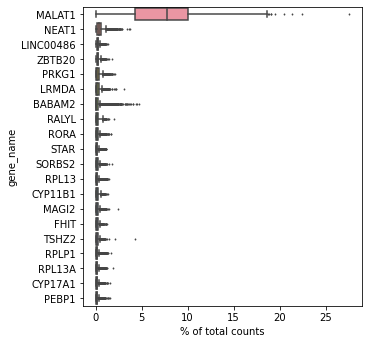

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

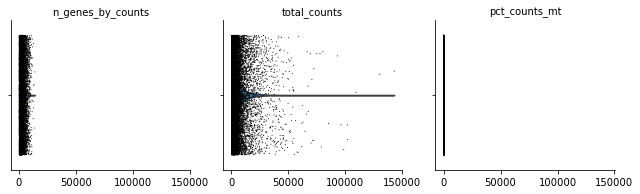

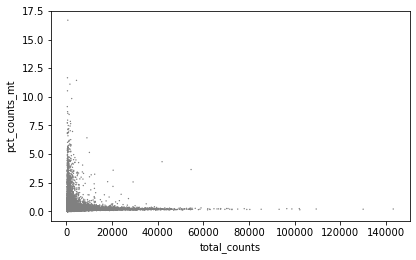

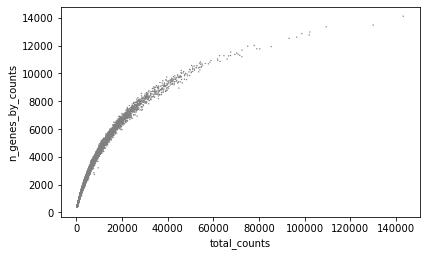

tenx solo rescue first phase QC


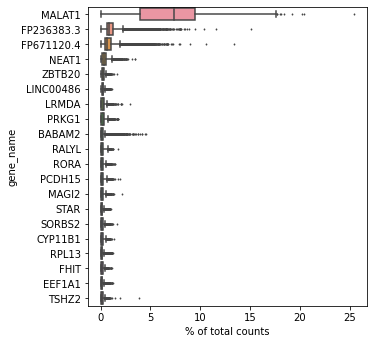

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

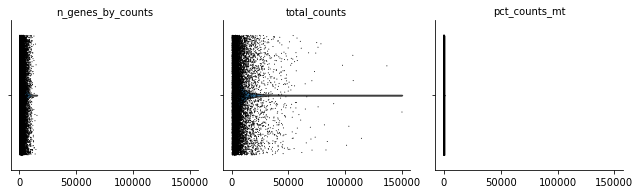

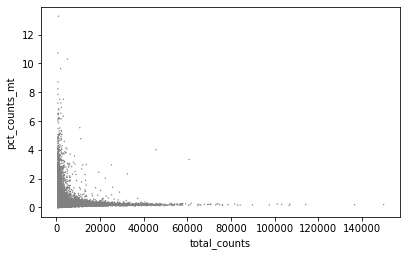

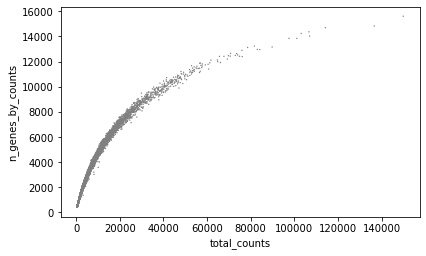

tenx solo em first phase QC


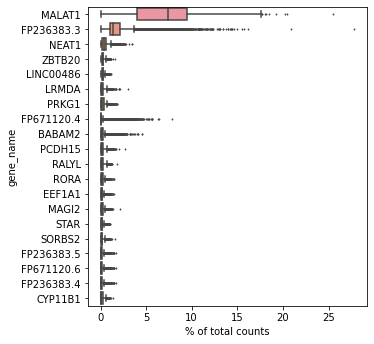

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

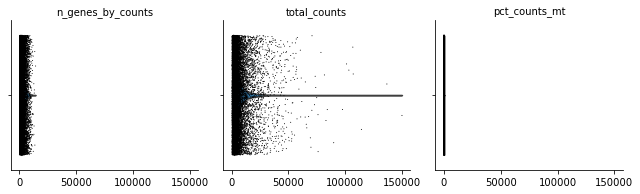

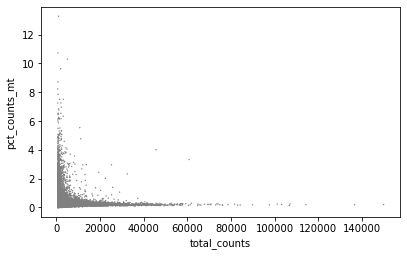

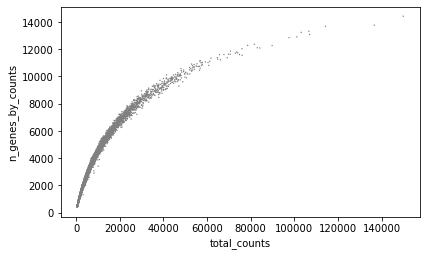

encode full solo uniq first phase QC


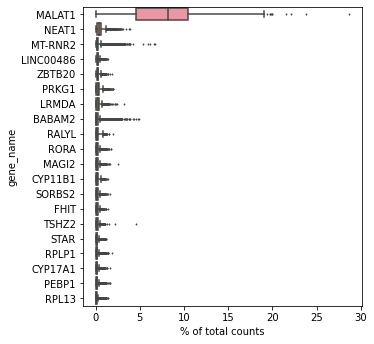

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

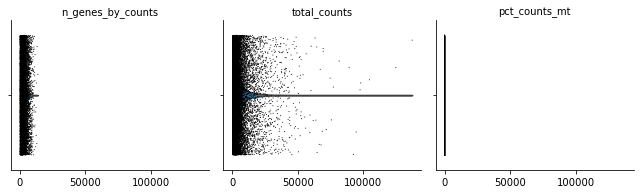

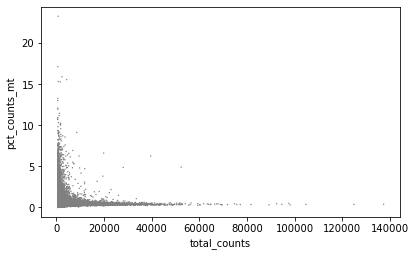

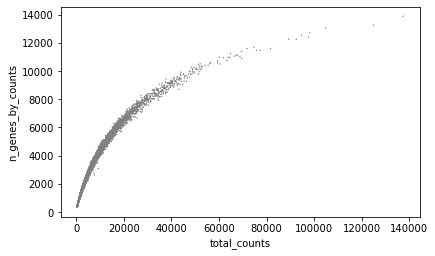

encode full solo rescue first phase QC


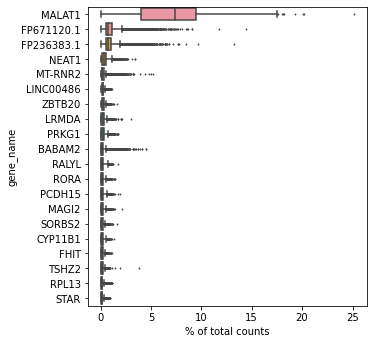

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

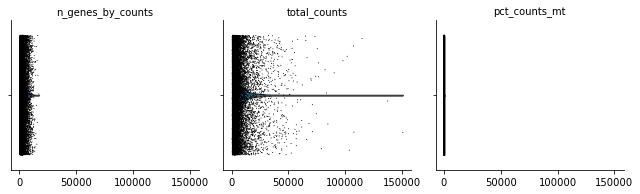

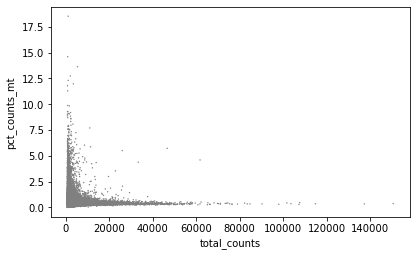

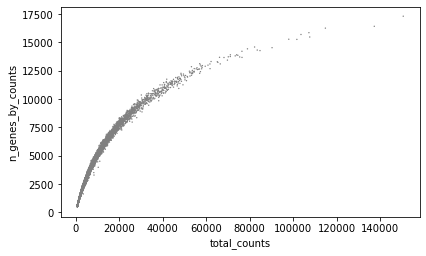

encode full solo em first phase QC


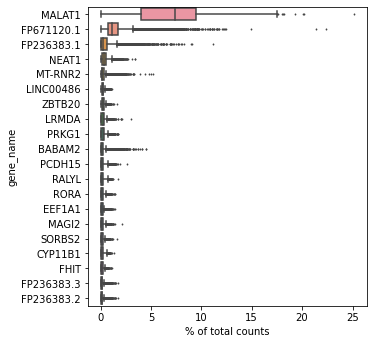

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

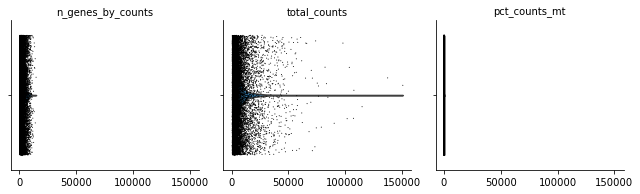

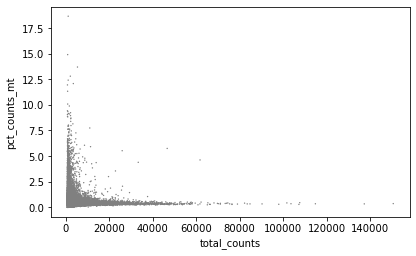

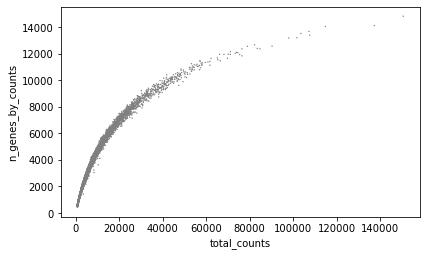

encode minimal solo uniq first phase QC


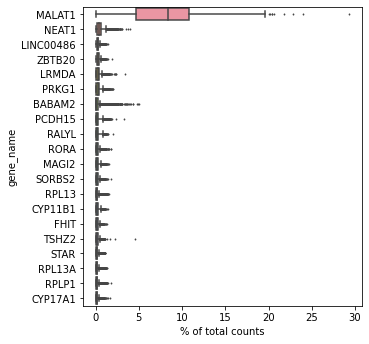

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

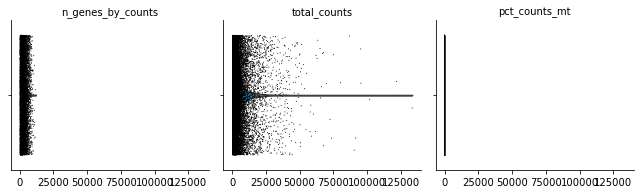

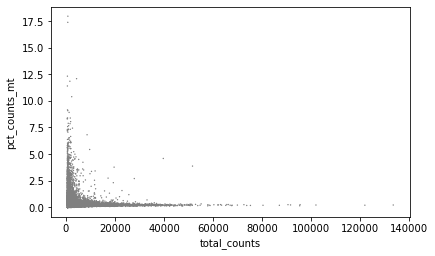

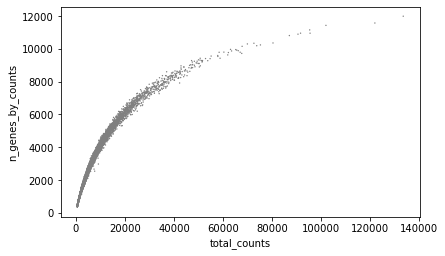

encode minimal solo rescue first phase QC


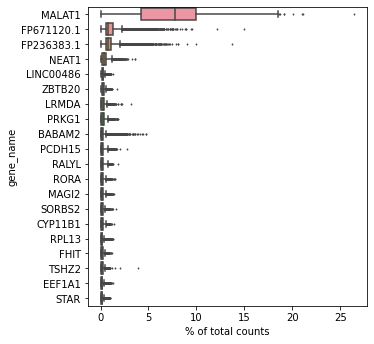

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

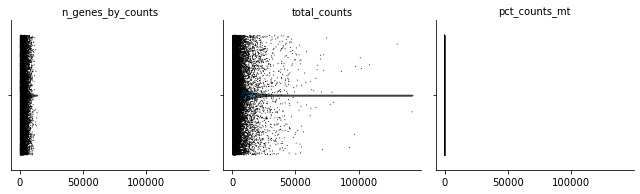

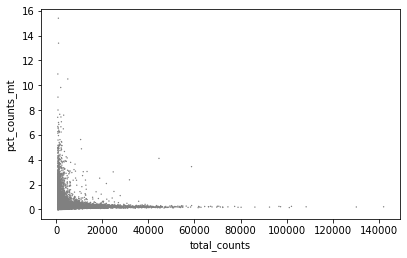

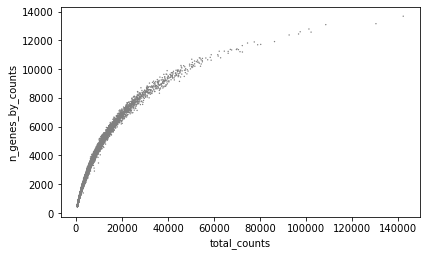

encode minimal solo em first phase QC


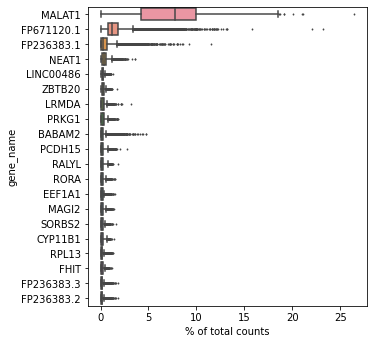

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

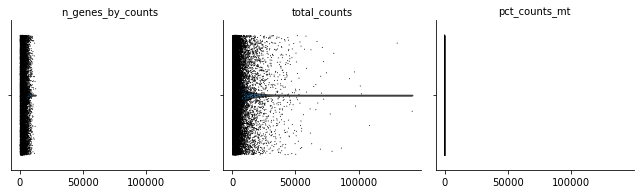

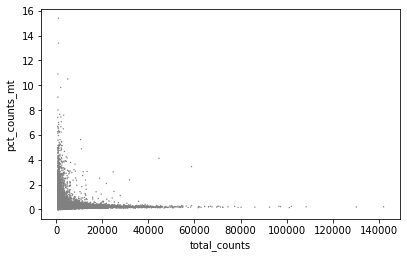

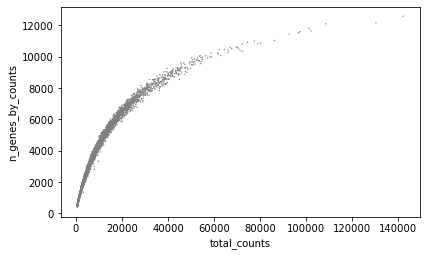

In [40]:
for algorithm in algorithm_filtered:
    print("{algorithm} first phase QC".format(algorithm=algorithm))    
    if algorithm.startswith("tenx"):
        algorithm_filtered[algorithm].var['gene_name'] = [v32m_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v32m_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
    else:
        algorithm_filtered[algorithm].var['gene_name'] = [v29_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v29_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        
    scanpy.pl.highest_expr_genes(algorithm_filtered[algorithm], n_top=20, gene_symbols='gene_name')
    scanpy.pp.filter_cells(algorithm_filtered[algorithm], min_genes=200)
    scanpy.pp.filter_genes(algorithm_filtered[algorithm], min_cells=3)
    algorithm_filtered[algorithm].var['mt'] = algorithm_filtered[algorithm].var['gene_name'].str.startswith("MT-")
    scanpy.pp.calculate_qc_metrics(algorithm_filtered[algorithm], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    scanpy.pl.violin(
        algorithm_filtered[algorithm],
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        jitter=0.4, multi_panel=True)
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='pct_counts_mt')
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='n_genes_by_counts')        

tenx solo uniq clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


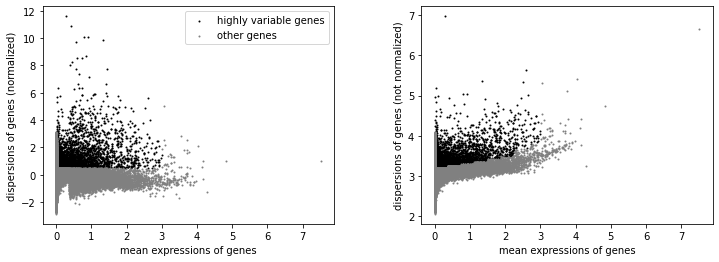

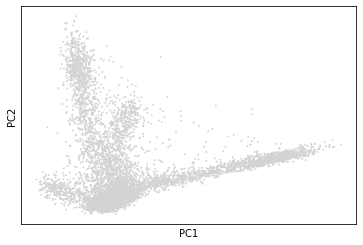

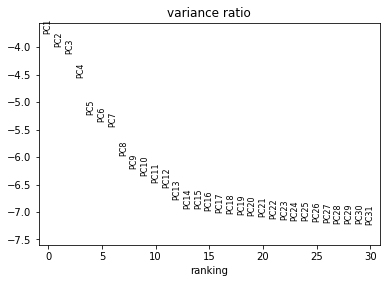

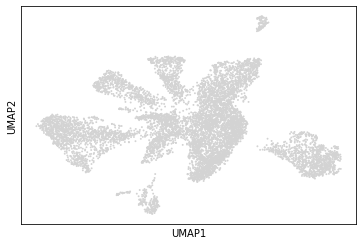

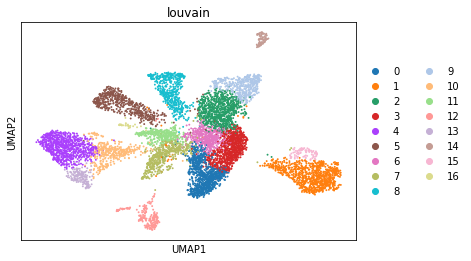

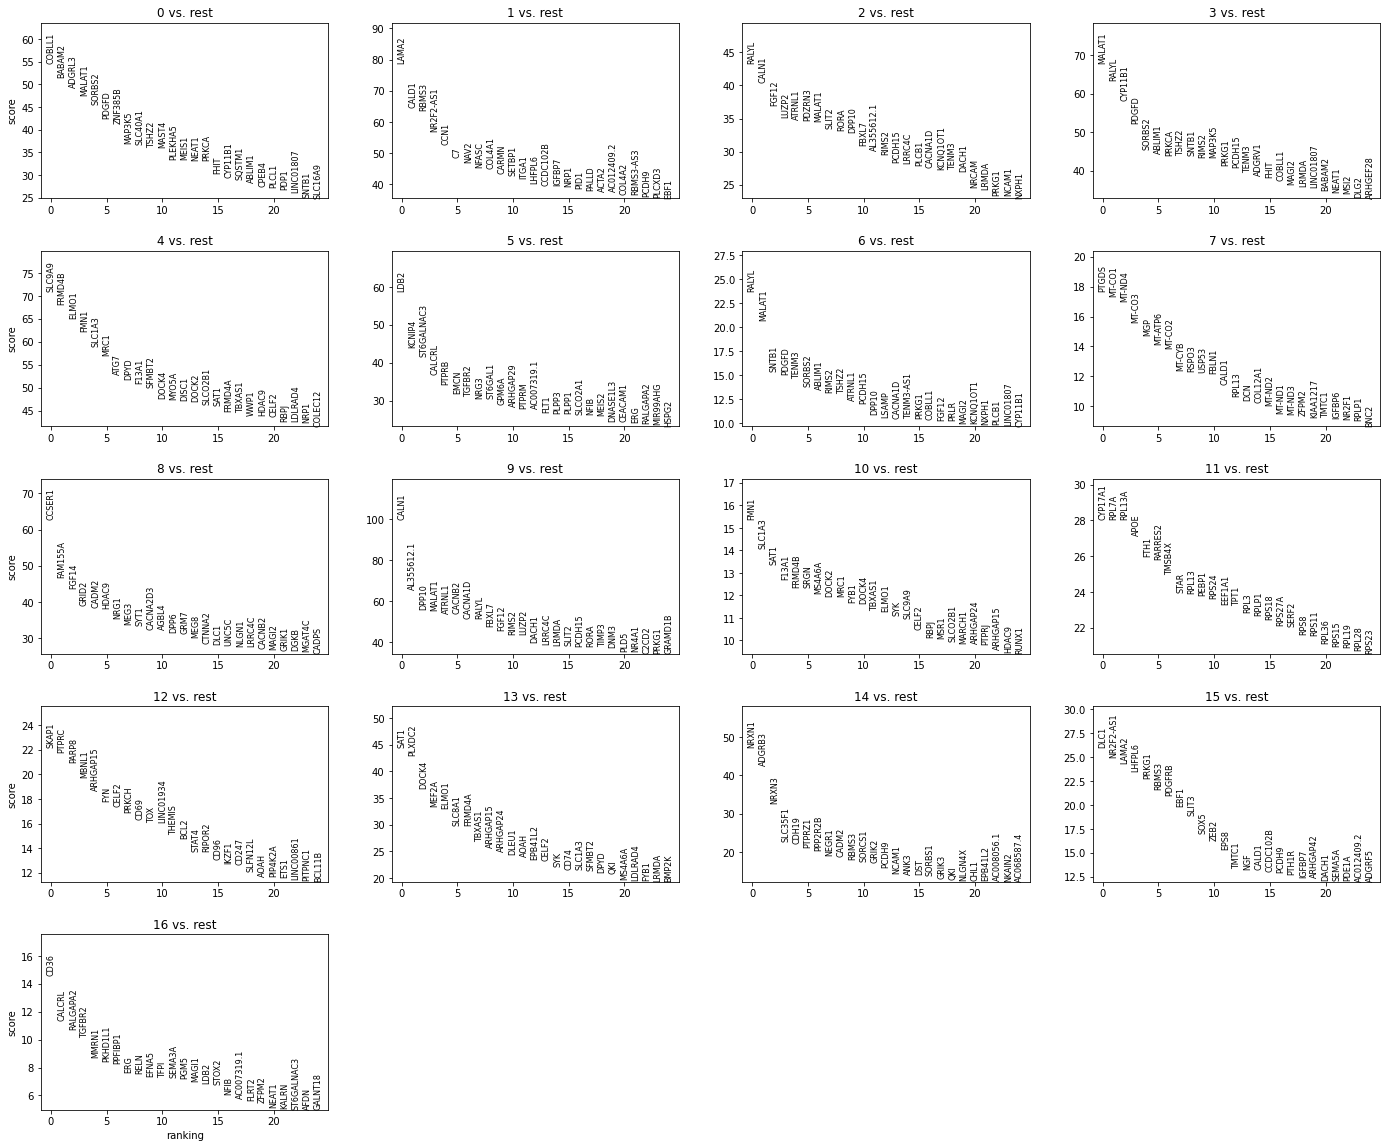

top gene names
        0          1       2        3       4           5       6       7  \
0  COBLL1      LAMA2   RALYL   MALAT1  SLC9A9        LDB2   RALYL   PTGDS   
1  BABAM2      CALD1   CALN1    RALYL  FRMD4B      KCNIP4  MALAT1  MT-CO1   
2  ADGRL3      RBMS3   FGF12  CYP11B1   ELMO1  ST6GALNAC3   SNTB1  MT-ND4   
3  MALAT1  NR2F2-AS1   LUZP2    PDGFD    FMN1      CALCRL   PDGFD  MT-CO3   
4  SORBS2       CCN1  ATRNL1   SORBS2  SLC1A3       PTPRB   TENM3     MGP   

         8           9      10       11        12      13       14         15  \
0   CCSER1       CALN1    FMN1  CYP17A1     SKAP1    SAT1    NRXN1       DLC1   
1  FAM155A  AL355612.1  SLC1A3    RPL7A     PTPRC  PLXDC2   ADGRB3  NR2F2-AS1   
2    FGF14       DPP10    SAT1   RPL13A     PARP8   DOCK4    NRXN3      LAMA2   
3    GRID2      MALAT1   F13A1     APOE     MBNL1   MEF2A  SLC35F1     LHFPL6   
4    CADM2      ATRNL1  FRMD4B     FTH1  ARHGAP15   ELMO1    CDH19      PRKG1   

         16  
0      CD36  
1    CA

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


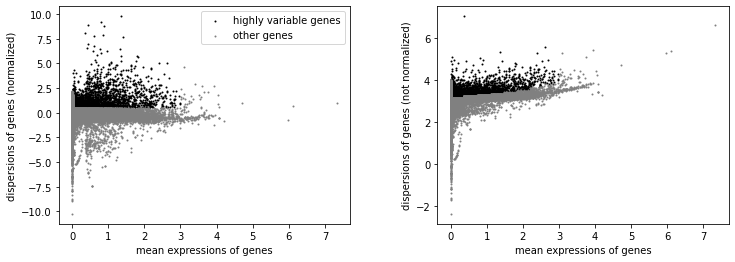

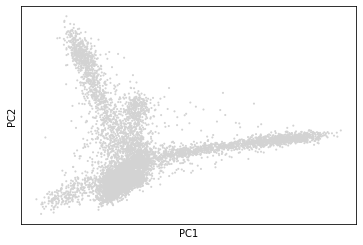

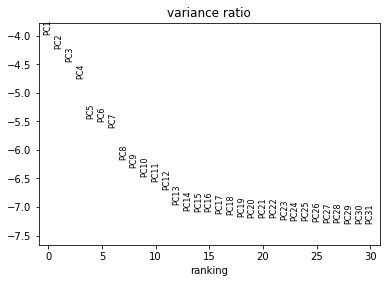

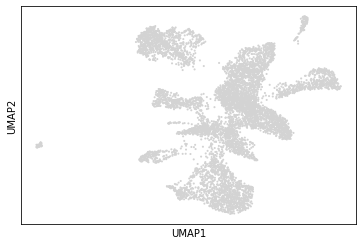

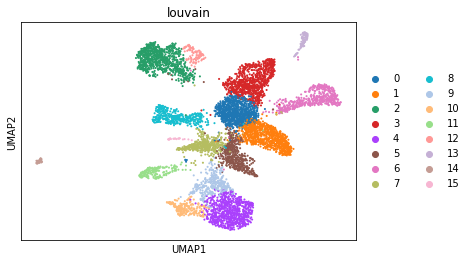

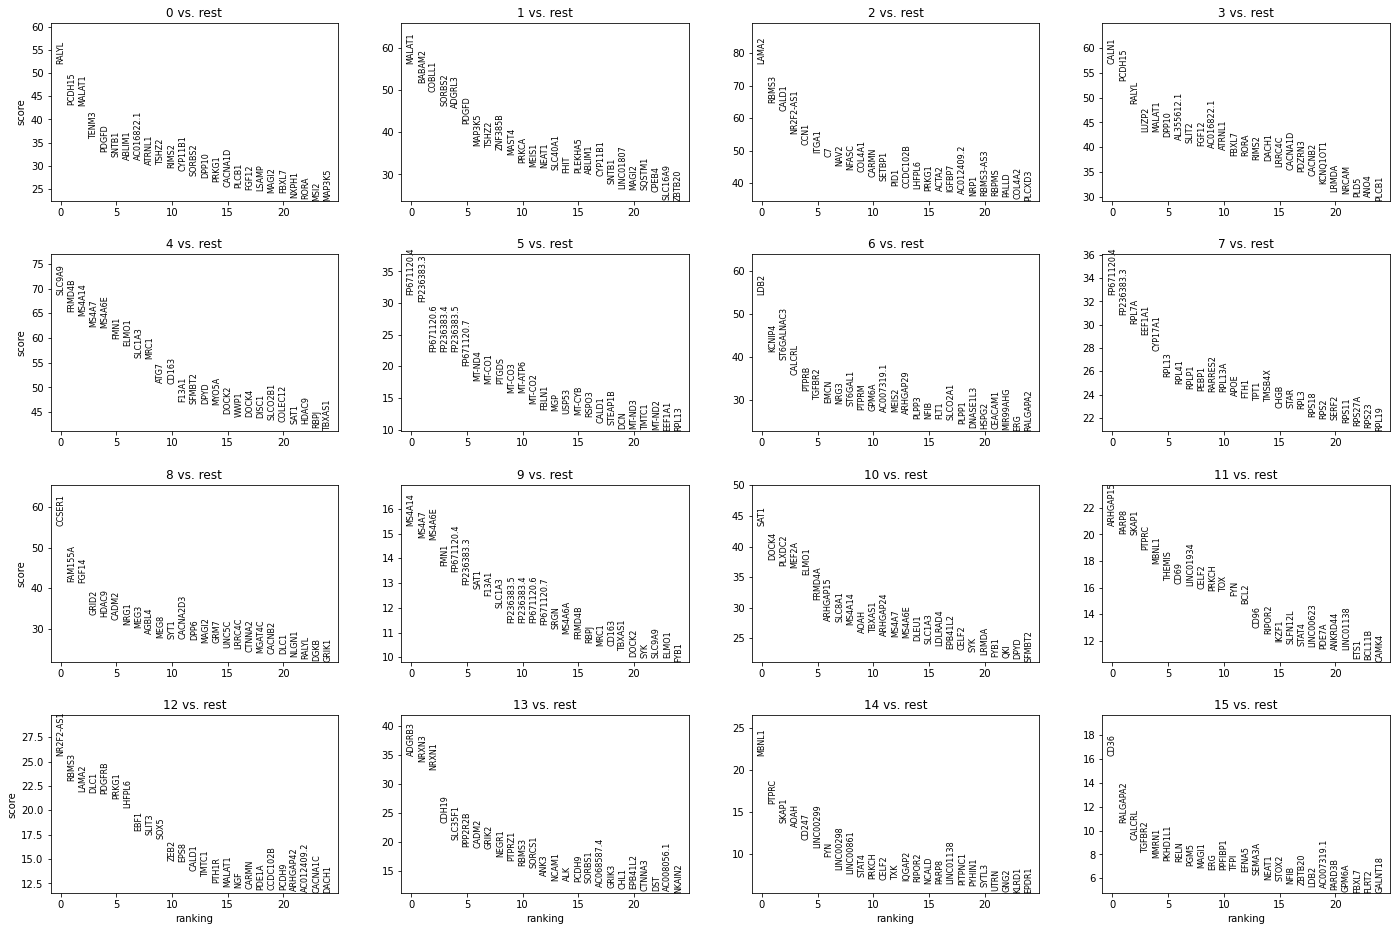

top gene names
        0       1          2       3       4           5           6  \
0   RALYL  MALAT1      LAMA2   CALN1  SLC9A9  FP671120.1        LDB2   
1  PCDH15  BABAM2      RBMS3  PCDH15  FRMD4B  FP236383.1      KCNIP4   
2  MALAT1  COBLL1      CALD1   RALYL  MS4A14  FP671120.3  ST6GALNAC3   
3   TENM3  SORBS2  NR2F2-AS1   LUZP2   MS4A7  FP236383.2      CALCRL   
4   PDGFD  ADGRL3      CYR61  MALAT1  MS4A6E  FP236383.3       PTPRB   

            7        8           9      10        11         12       13  \
0  FP671120.1   CCSER1      MS4A14    SAT1  ARHGAP15  NR2F2-AS1   ADGRB3   
1  FP236383.1  FAM155A       MS4A7   DOCK4     PARP8      RBMS3    NRXN3   
2       RPL7A    FGF14      MS4A6E  PLXDC2     SKAP1      LAMA2    NRXN1   
3      EEF1A1    GRID2        FMN1   MEF2A     PTPRC       DLC1    CDH19   
4     CYP17A1    HDAC9  FP671120.1   ELMO1     MBNL1     PDGFRB  SLC35F1   

      14        15  
0  MBNL1      CD36  
1  PTPRC  RALGAPA2  
2  SKAP1    CALCRL  
3   AOAH   

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


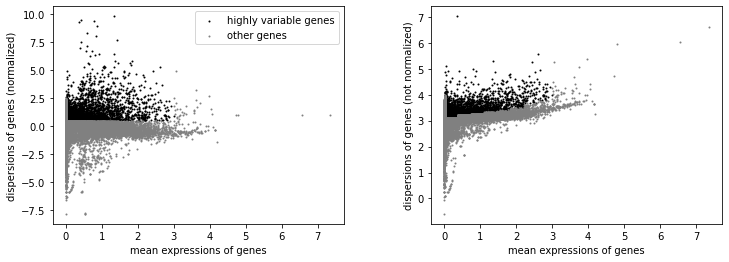

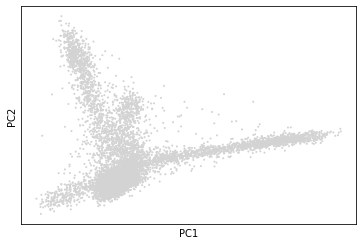

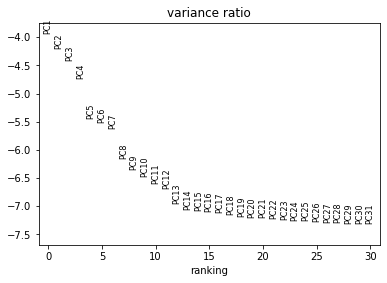

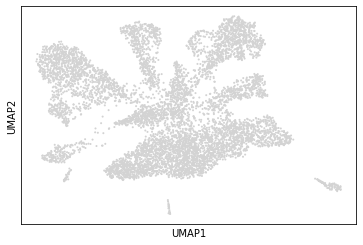

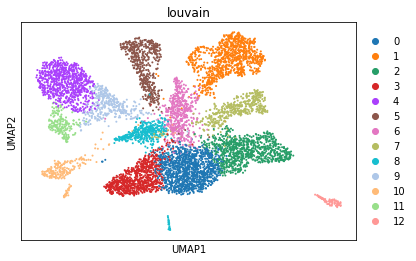

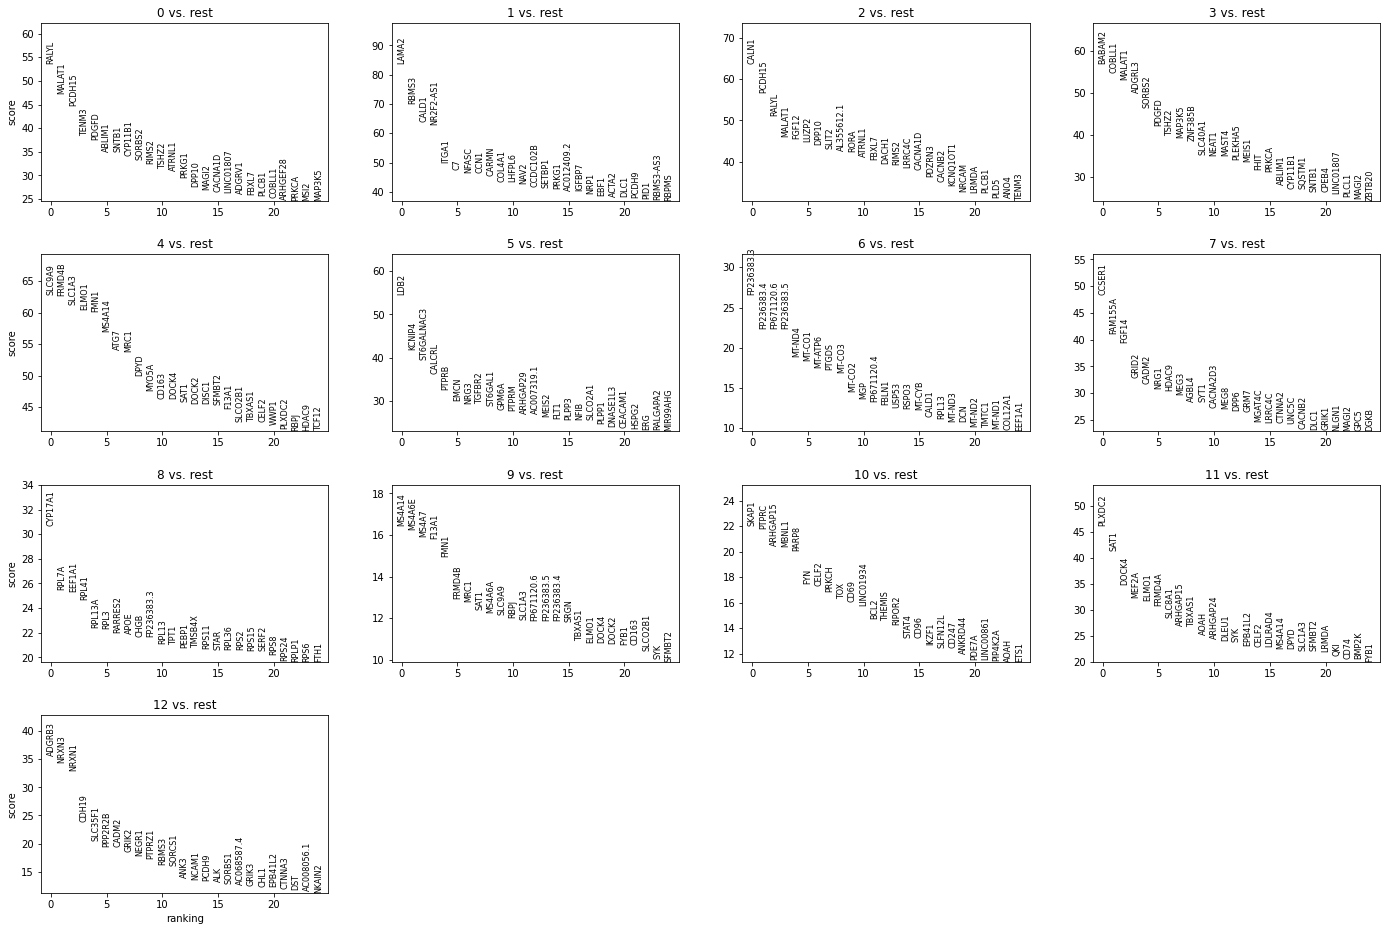

top gene names
        0          1       2       3       4           5           6        7  \
0   RALYL      LAMA2   CALN1  BABAM2  SLC9A9        LDB2  FP236383.1   CCSER1   
1  MALAT1      RBMS3  PCDH15  COBLL1  FRMD4B      KCNIP4  FP236383.2  FAM155A   
2  PCDH15      CALD1   RALYL  MALAT1  SLC1A3  ST6GALNAC3  FP671120.3    FGF14   
3   TENM3  NR2F2-AS1  MALAT1  ADGRL3   ELMO1      CALCRL  FP236383.3    GRID2   
4   PDGFD      ITGA1   FGF12  SORBS2    FMN1       PTPRB      MT-ND4    CADM2   

         8       9        10      11       12  
0  CYP17A1  MS4A14     SKAP1  PLXDC2   ADGRB3  
1    RPL7A  MS4A6E     PTPRC    SAT1    NRXN3  
2   EEF1A1   MS4A7  ARHGAP15   DOCK4    NRXN1  
3    RPL41   F13A1     MBNL1   MEF2A    CDH19  
4   RPL13A    FMN1     PARP8   ELMO1  SLC35F1  
encode full solo uniq clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


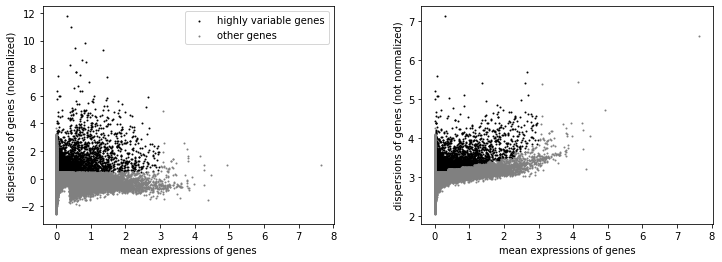

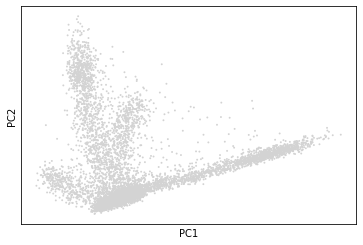

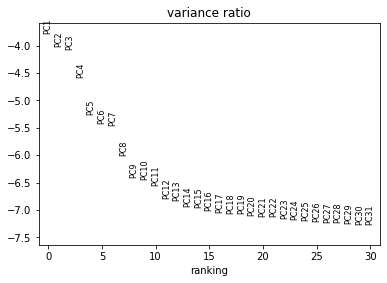

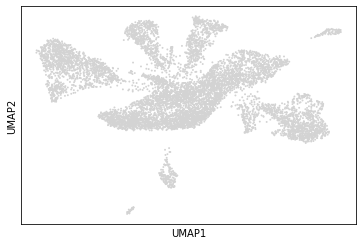

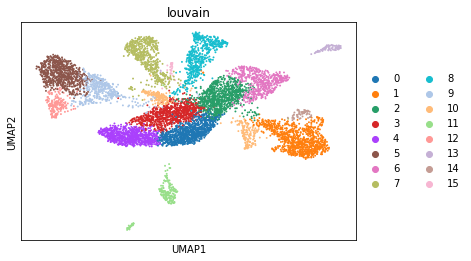

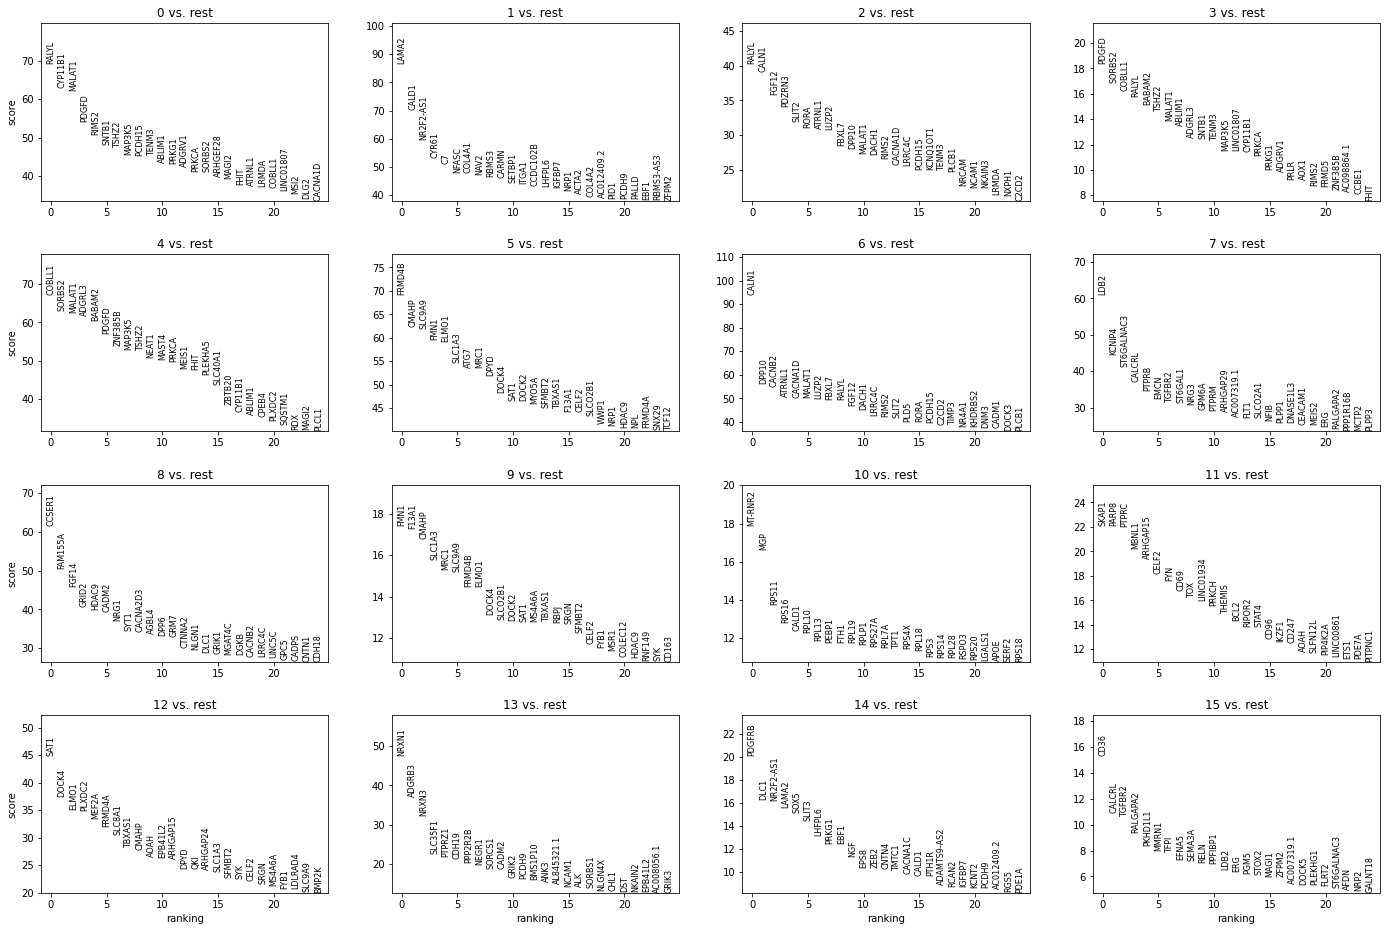

top gene names
         0          1       2       3       4       5        6           7  \
0    RALYL      LAMA2   RALYL   PDGFD  COBLL1  FRMD4B    CALN1        LDB2   
1  CYP11B1      CALD1   CALN1  SORBS2  SORBS2   CMAHP    DPP10      KCNIP4   
2   MALAT1  NR2F2-AS1   FGF12  COBLL1  MALAT1  SLC9A9   CACNB2  ST6GALNAC3   
3    PDGFD      CYR61  PDZRN3   RALYL  ADGRL3    FMN1   ATRNL1      CALCRL   
4    RIMS2         C7   SLIT2  BABAM2  BABAM2   ELMO1  CACNA1D       PTPRB   

         8       9       10        11      12       13         14        15  
0   CCSER1    FMN1  MT-RNR2     SKAP1    SAT1    NRXN1     PDGFRB      CD36  
1  FAM155A   F13A1      MGP     PARP8   DOCK4   ADGRB3       DLC1    CALCRL  
2    FGF14   CMAHP    RPS11     PTPRC   ELMO1    NRXN3  NR2F2-AS1    TGFBR2  
3    GRID2  SLC1A3    RPS16     MBNL1  PLXDC2  SLC35F1      LAMA2  RALGAPA2  
4    HDAC9    MRC1    CALD1  ARHGAP15   MEF2A   PTPRZ1       SOX5   PKHD1L1  
encode full solo rescue clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


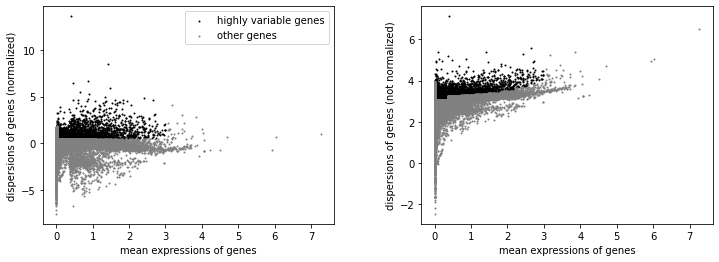

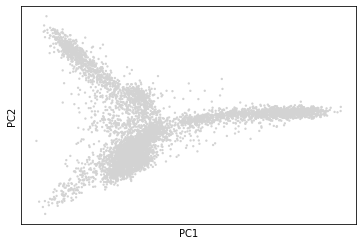

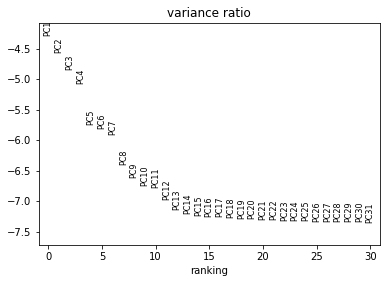

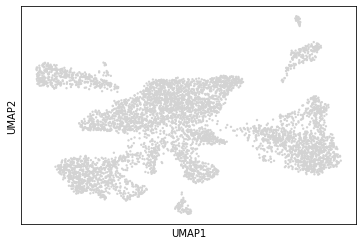

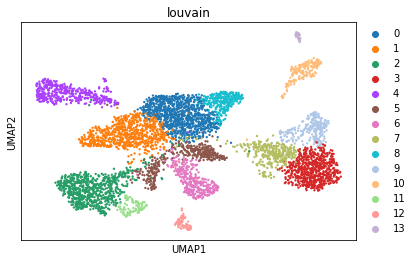

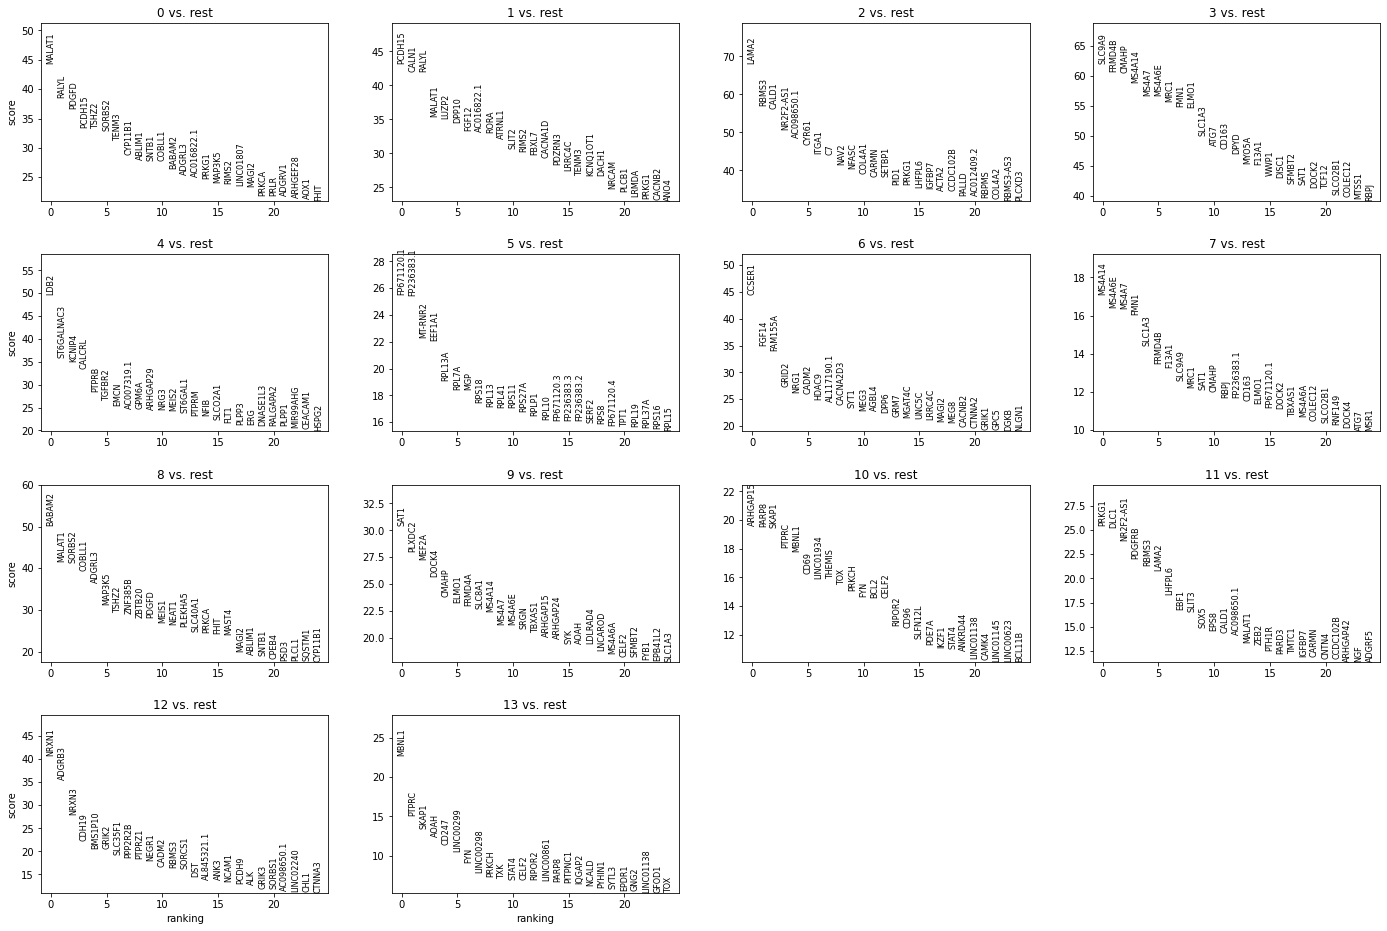

top gene names
        0       1           2       3           4           5        6  \
0  MALAT1  PCDH15       LAMA2  SLC9A9        LDB2  FP671120.1   CCSER1   
1   RALYL   CALN1       RBMS3  FRMD4B  ST6GALNAC3  FP236383.1    FGF14   
2   PDGFD   RALYL       CALD1   CMAHP      KCNIP4     MT-RNR2  FAM155A   
3  PCDH15  MALAT1   NR2F2-AS1  MS4A14      CALCRL      EEF1A1    GRID2   
4   TSHZ2   LUZP2  AC098650.1   MS4A7       PTPRB      RPL13A     NRG1   

        7       8       9        10         11       12     13  
0  MS4A14  BABAM2    SAT1  ARHGAP15      PRKG1    NRXN1  MBNL1  
1  MS4A6E  MALAT1  PLXDC2     PARP8       DLC1   ADGRB3  PTPRC  
2   MS4A7  SORBS2   MEF2A     SKAP1  NR2F2-AS1    NRXN3  SKAP1  
3    FMN1  COBLL1   DOCK4     PTPRC     PDGFRB    CDH19   AOAH  
4  SLC1A3  ADGRL3   CMAHP     MBNL1      RBMS3  BMS1P10  CD247  
encode full solo em clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


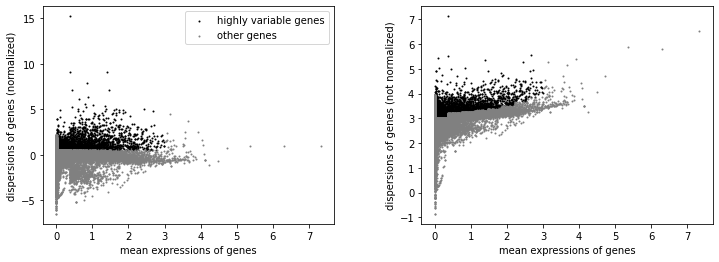

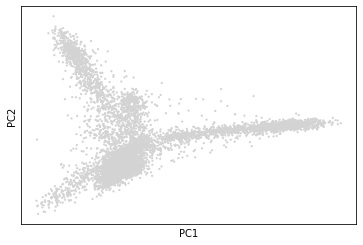

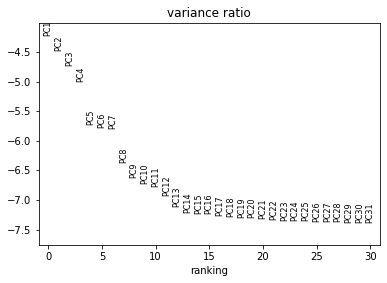

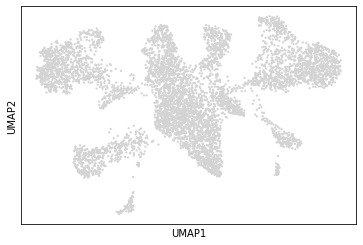

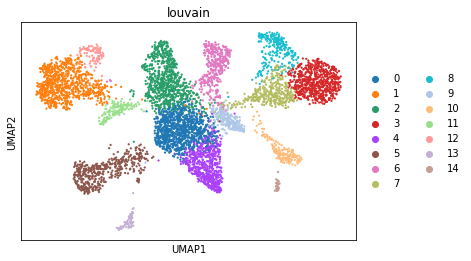

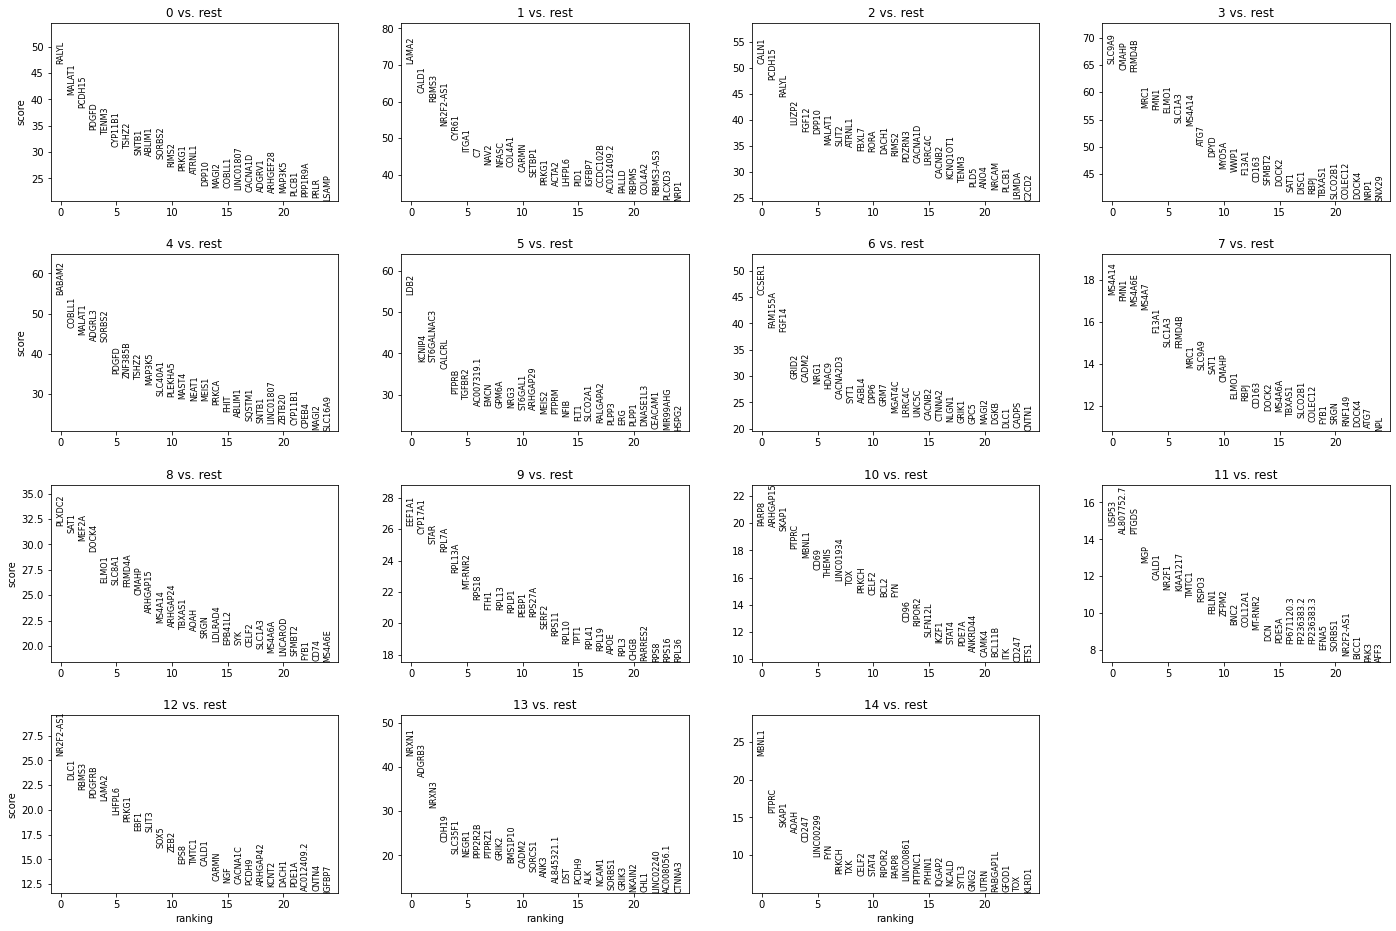

top gene names
        0          1       2       3       4           5        6       7  \
0   RALYL      LAMA2   CALN1  SLC9A9  BABAM2        LDB2   CCSER1  MS4A14   
1  MALAT1      CALD1  PCDH15   CMAHP  COBLL1      KCNIP4  FAM155A    FMN1   
2  PCDH15      RBMS3   RALYL  FRMD4B  MALAT1  ST6GALNAC3    FGF14  MS4A6E   
3   PDGFD  NR2F2-AS1   LUZP2    MRC1  ADGRL3      CALCRL    GRID2   MS4A7   
4   TENM3      CYR61   FGF12    FMN1  SORBS2       PTPRB    CADM2   F13A1   

        8        9        10          11         12       13     14  
0  PLXDC2   EEF1A1     PARP8       USP53  NR2F2-AS1    NRXN1  MBNL1  
1    SAT1  CYP17A1  ARHGAP15  AL807752.7       DLC1   ADGRB3  PTPRC  
2   MEF2A     STAR     SKAP1       PTGDS      RBMS3    NRXN3  SKAP1  
3   DOCK4    RPL7A     PTPRC         MGP     PDGFRB    CDH19   AOAH  
4   ELMO1   RPL13A     MBNL1       CALD1      LAMA2  SLC35F1  CD247  
encode minimal solo uniq clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


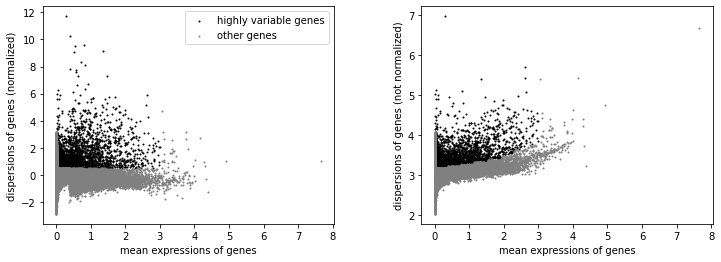

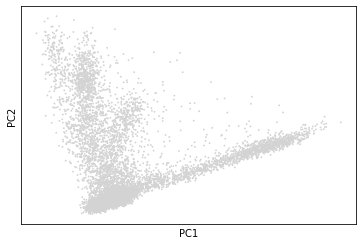

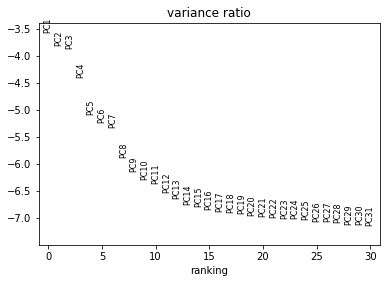

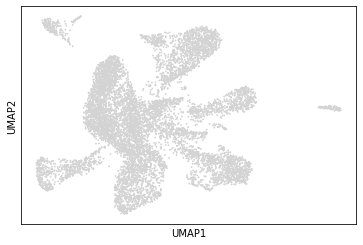

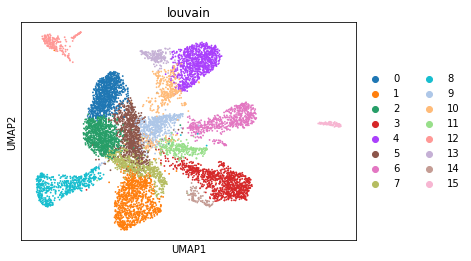

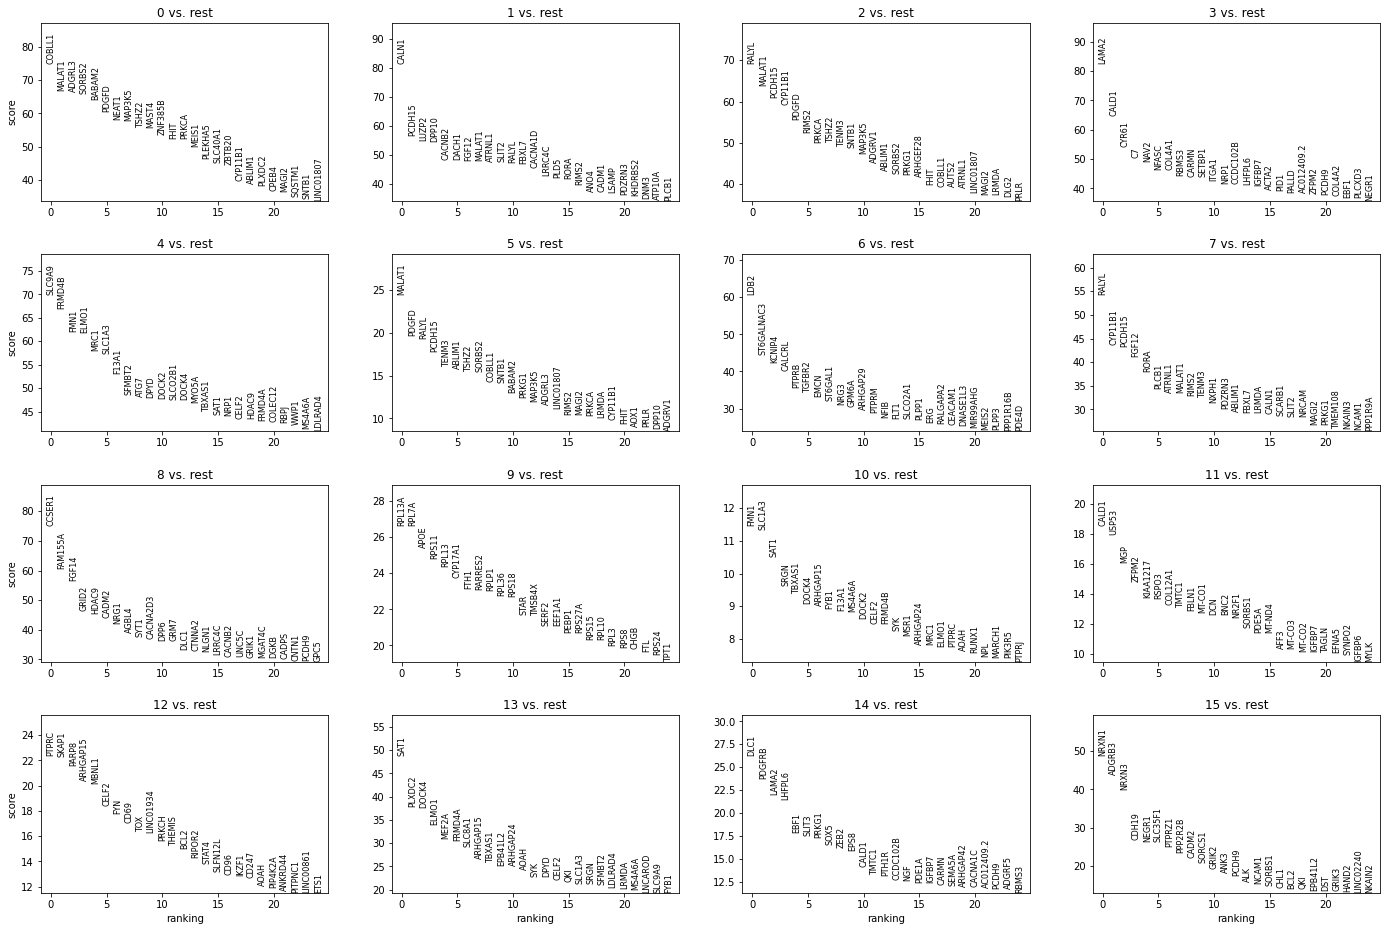

top gene names
        0       1        2      3       4       5           6        7  \
0  COBLL1   CALN1    RALYL  LAMA2  SLC9A9  MALAT1        LDB2    RALYL   
1  MALAT1  PCDH15   MALAT1  CALD1  FRMD4B   PDGFD  ST6GALNAC3  CYP11B1   
2  ADGRL3   LUZP2   PCDH15  CYR61    FMN1   RALYL      KCNIP4   PCDH15   
3  SORBS2   DPP10  CYP11B1     C7   ELMO1  PCDH15      CALCRL    FGF12   
4  BABAM2  CACNB2    PDGFD   NAV2    MRC1   TENM3       PTPRB     RORA   

         8       9      10        11        12      13      14      15  
0   CCSER1  RPL13A    FMN1     CALD1     PTPRC    SAT1    DLC1   NRXN1  
1  FAM155A   RPL7A  SLC1A3     USP53     SKAP1  PLXDC2  PDGFRB  ADGRB3  
2    FGF14    APOE    SAT1       MGP     PARP8   DOCK4   LAMA2   NRXN3  
3    GRID2   RPS11    SRGN     ZFPM2  ARHGAP15   ELMO1  LHFPL6   CDH19  
4    HDAC9   RPL13  TBXAS1  KIAA1217     MBNL1   MEF2A    EBF1   NEGR1  
encode minimal solo rescue clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


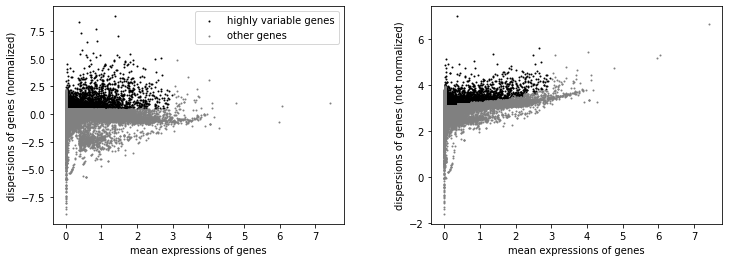

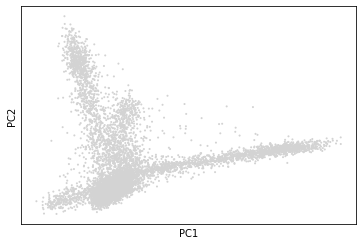

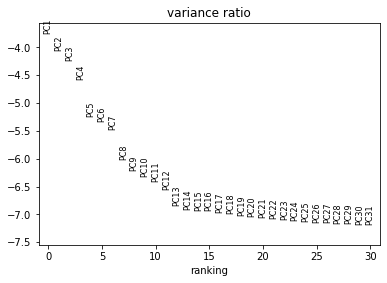

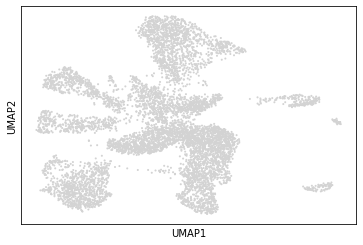

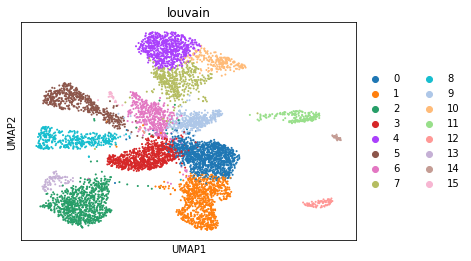

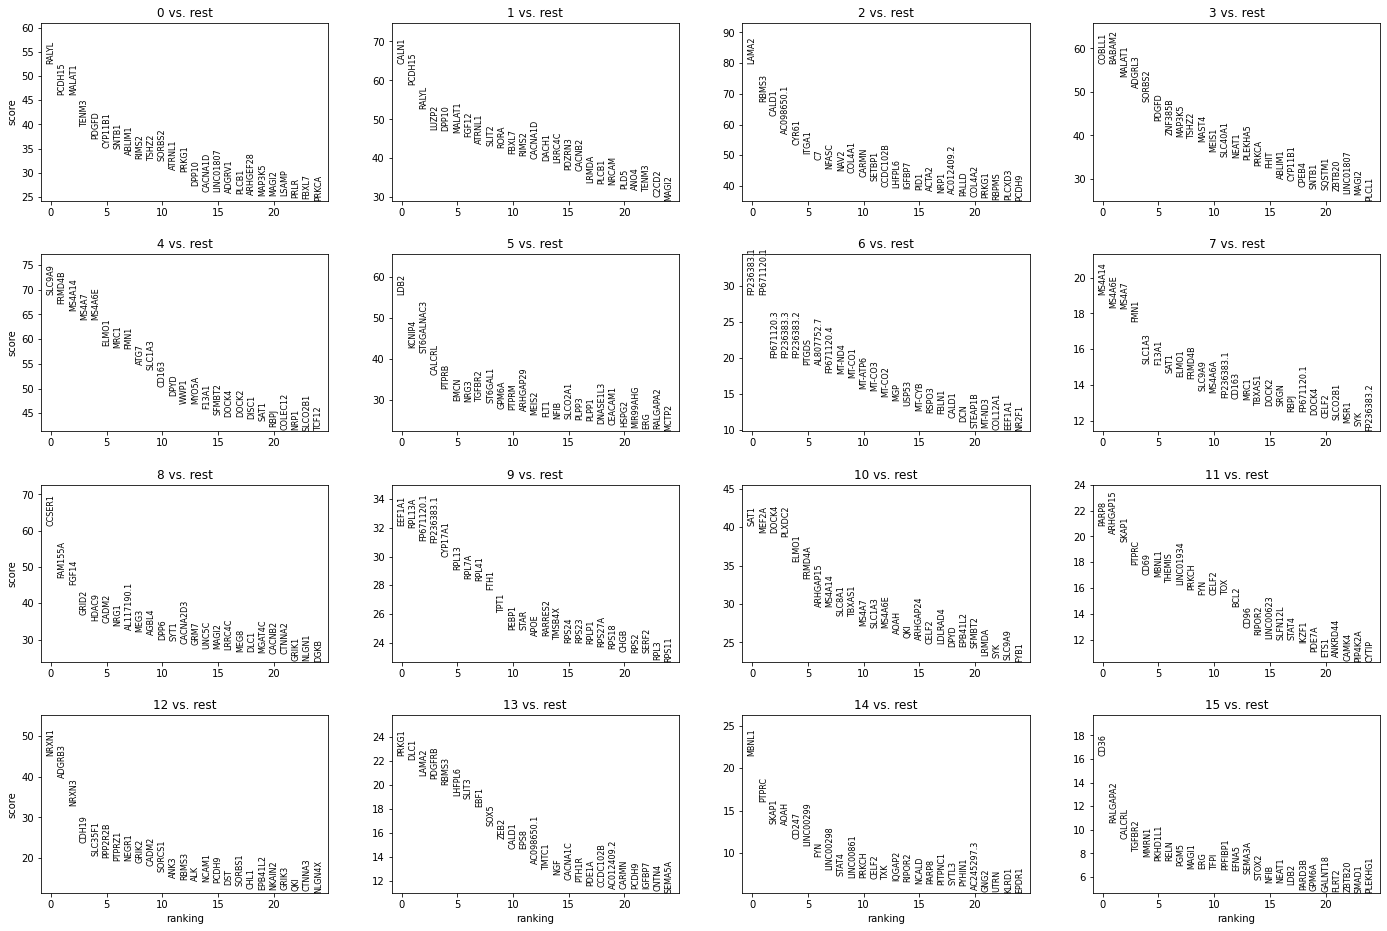

top gene names
        0       1           2       3       4           5           6       7  \
0   RALYL   CALN1       LAMA2  COBLL1  SLC9A9        LDB2  FP236383.1  MS4A14   
1  PCDH15  PCDH15       RBMS3  BABAM2  FRMD4B      KCNIP4  FP671120.1  MS4A6E   
2  MALAT1   RALYL       CALD1  MALAT1  MS4A14  ST6GALNAC3  FP671120.3   MS4A7   
3   TENM3   LUZP2  AC098650.1  ADGRL3   MS4A7      CALCRL  FP236383.3    FMN1   
4   PDGFD   DPP10       CYR61  SORBS2  MS4A6E       PTPRB  FP236383.2  SLC1A3   

         8           9      10        11       12      13     14        15  
0   CCSER1      EEF1A1    SAT1     PARP8    NRXN1   PRKG1  MBNL1      CD36  
1  FAM155A      RPL13A   MEF2A  ARHGAP15   ADGRB3    DLC1  PTPRC  RALGAPA2  
2    FGF14  FP671120.1   DOCK4     SKAP1    NRXN3   LAMA2  SKAP1    CALCRL  
3    GRID2  FP236383.1  PLXDC2     PTPRC    CDH19  PDGFRB   AOAH    TGFBR2  
4    HDAC9     CYP17A1   ELMO1      CD69  SLC35F1   RBMS3  CD247     MMRN1  
encode minimal solo em clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


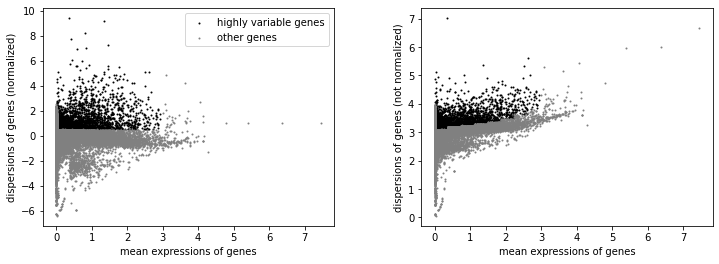

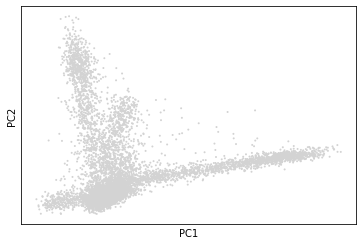

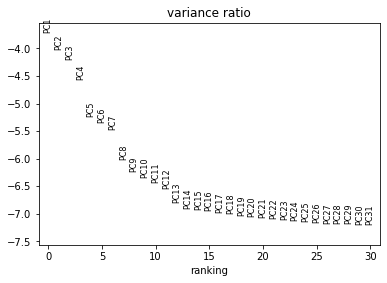

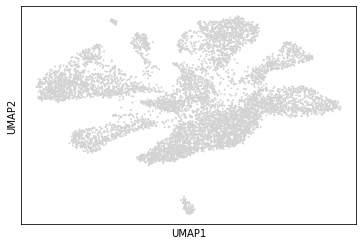

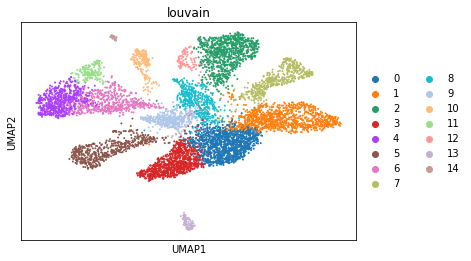

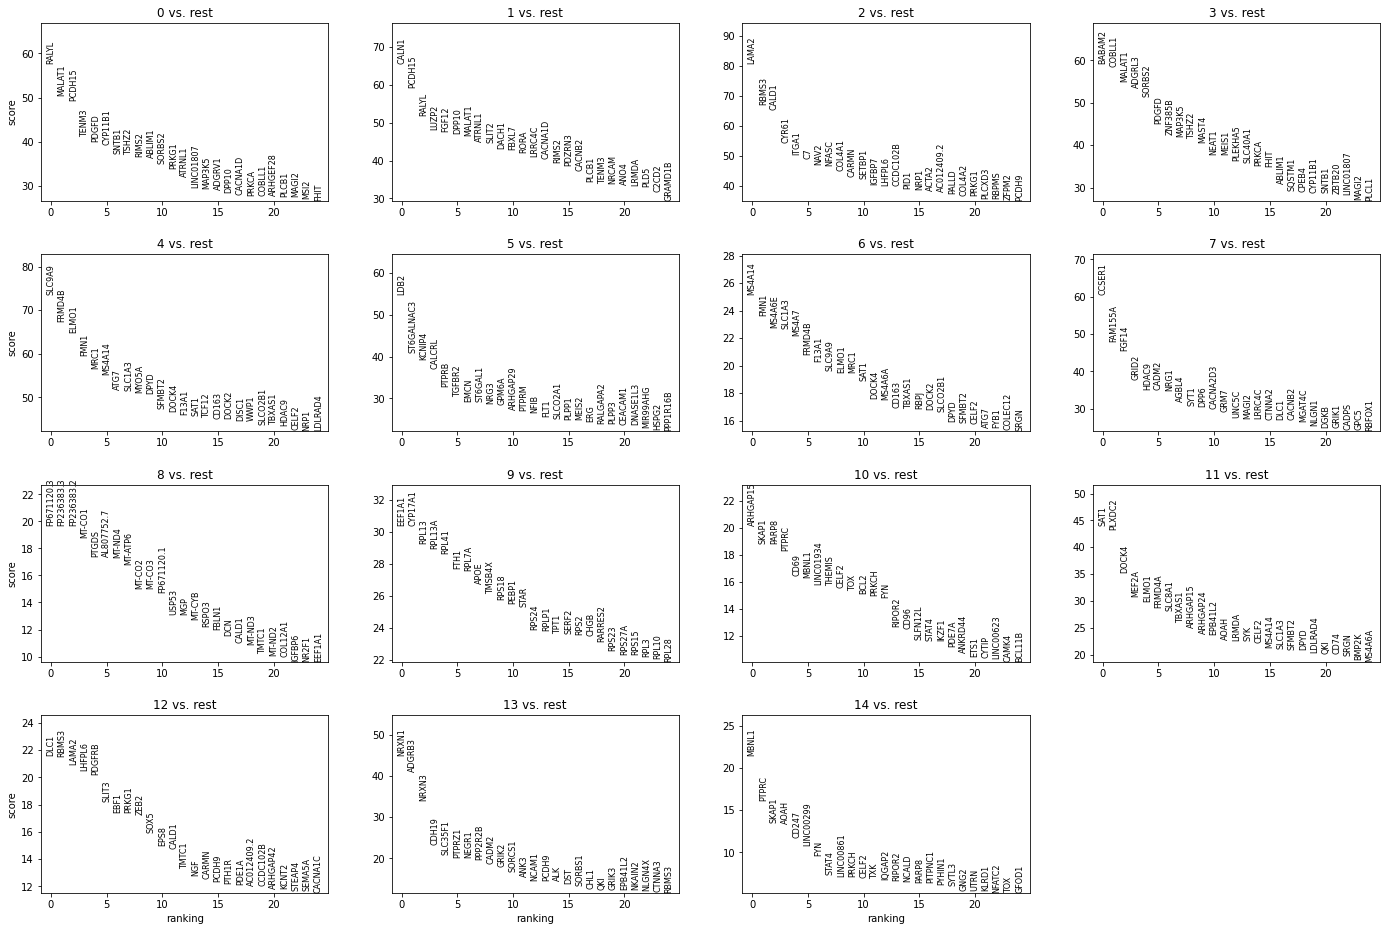

top gene names
        0       1      2       3       4           5       6        7  \
0   RALYL   CALN1  LAMA2  BABAM2  SLC9A9        LDB2  MS4A14   CCSER1   
1  MALAT1  PCDH15  RBMS3  COBLL1  FRMD4B  ST6GALNAC3    FMN1  FAM155A   
2  PCDH15   RALYL  CALD1  MALAT1   ELMO1      KCNIP4  MS4A6E    FGF14   
3   TENM3   LUZP2  CYR61  ADGRL3    FMN1      CALCRL  SLC1A3    GRID2   
4   PDGFD   FGF12  ITGA1  SORBS2    MRC1       PTPRB   MS4A7    HDAC9   

            8        9        10      11      12       13     14  
0  FP671120.3   EEF1A1  ARHGAP15    SAT1    DLC1    NRXN1  MBNL1  
1  FP236383.3  CYP17A1     SKAP1  PLXDC2   RBMS3   ADGRB3  PTPRC  
2  FP236383.2    RPL13     PARP8   DOCK4   LAMA2    NRXN3  SKAP1  
3      MT-CO1   RPL13A     PTPRC   MEF2A  LHFPL6    CDH19   AOAH  
4       PTGDS    RPL41      CD69   ELMO1  PDGFRB  SLC35F1  CD247  


In [41]:
algorithm_scanpy_filtered = {}
algorithm_top_gene_ids = {}
algorithm_top_gene_names = {}
for algorithm in algorithm_filtered:
    #print(display.HTML('<h1>{algorithm} first phase QC</h1><a class="anchor-link" href="#{algorithm}-first-phase-QC">¶</a>'.format(algorithm=algorithm)))
    print("{algorithm} clustering".format(algorithm=algorithm))
    algorithm_scanpy_filtered[algorithm] = algorithm_filtered[algorithm][algorithm_filtered[algorithm].obs.n_genes_by_counts < 2000, :]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][algorithm_scanpy_filtered[algorithm].obs.pct_counts_mt < 2.5, :]
    
    scanpy.pp.normalize_total(algorithm_scanpy_filtered[algorithm], target_sum=30000)
    scanpy.pp.log1p(algorithm_scanpy_filtered[algorithm])
    scanpy.pp.highly_variable_genes(algorithm_scanpy_filtered[algorithm], min_mean=0.0125, max_mean=3, min_disp=0.5)
    scanpy.pl.highly_variable_genes(algorithm_scanpy_filtered[algorithm])
    algorithm_scanpy_filtered[algorithm].raw = algorithm_scanpy_filtered[algorithm]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][:, algorithm_scanpy_filtered[algorithm].var.highly_variable]
   
    scanpy.pp.regress_out( algorithm_scanpy_filtered[algorithm], ['total_counts', 'pct_counts_mt'])
    scanpy.pp.scale( algorithm_scanpy_filtered[algorithm], max_value=10)
    scanpy.tl.pca(algorithm_scanpy_filtered[algorithm], svd_solver='arpack')
    scanpy.pl.pca(algorithm_scanpy_filtered[algorithm])

    scanpy.pl.pca_variance_ratio(algorithm_scanpy_filtered[algorithm], log=True)
    
    scanpy.pp.neighbors(algorithm_scanpy_filtered[algorithm], n_neighbors=10, n_pcs=40)
    scanpy.tl.umap(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm])
    
    scanpy.tl.louvain(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm], color=['louvain'])
    
    scanpy.tl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], 'louvain', method='t-test')
    scanpy.pl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], n_genes=25, sharey=False, gene_symbols='gene_name')
    
    algorithm_top_gene_ids[algorithm] = pandas.DataFrame(algorithm_scanpy_filtered[algorithm].uns['rank_genes_groups']['names'])    
    if algorithm == "tenx solo uniq":
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v32m_gene_id_to_name.get(x, x))
    else:
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v29_gene_id_to_name.get(x, x))
    print('top gene names')
    print(algorithm_top_gene_names[algorithm].head(5))

# Cell barcodes left in common after scanpy filtering

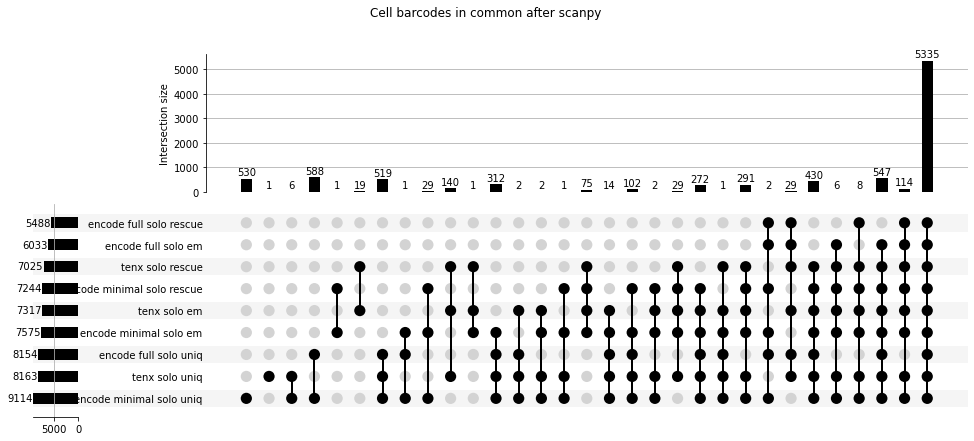

In [42]:
tutoral_barcode_set = upsetplot.from_contents({
    k: algorithm_scanpy_filtered[k].obs_names for k in algorithm_scanpy_filtered
})
f = pyplot.figure()
f.suptitle("Cell barcodes in common after scanpy")
_ = upsetplot.plot(tutoral_barcode_set, show_counts=True, fig=f)


# Gene IDs in common after scanpy filtering

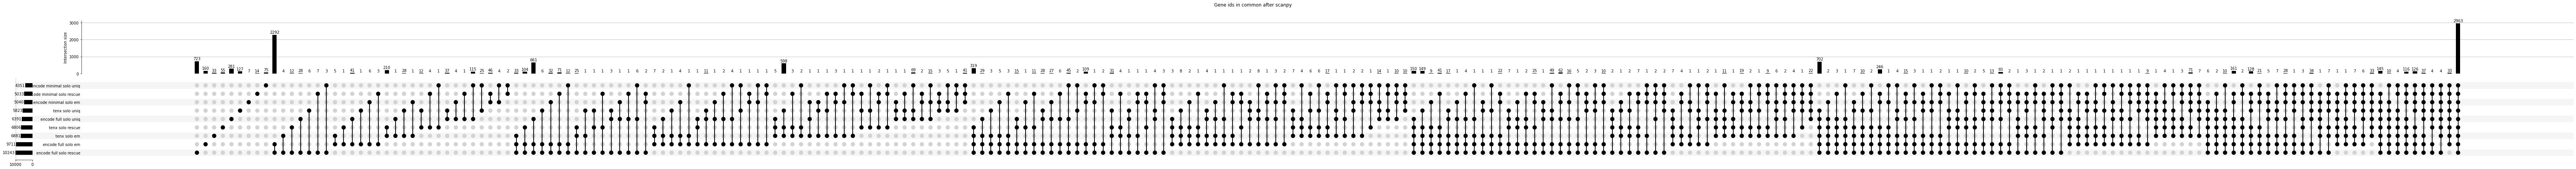

In [43]:
common_filtered_gene_base_contents = {}
for algorithm in algorithm_scanpy_filtered:
    #if algorithm == 'tenx solo uniq':
    #    common_filtered_gene_base_contents[algorithm] = {gene_id for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    #else:
    #common_filtered_gene_base_contents[algorithm] = {gene_id.split('.')[0] for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    common_filtered_gene_base_contents[algorithm] = set(algorithm_scanpy_filtered[algorithm].var_names)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
common_filtered_gene_base_set = upsetplot.from_contents(common_filtered_gene_base_contents)

f = pyplot.figure()
f.suptitle("Gene ids in common after scanpy")
_ = upsetplot.plot(common_filtered_gene_base_set, show_counts=True, fig=f)

In [44]:
common_filtered_gene_base_set

id
tenx solo uniq tenx solo rescue tenx solo em encode full solo uniq encode full solo rescue encode full solo em encode minimal solo uniq encode minimal solo rescue encode minimal solo em                    
True           True             True         True                  True                    True                True                     True                       True                     ENSG00000274367.1
                                             False                 False                   False               False                    False                      False                   ENSG00000167723.14
                                                                                                                                                                   False                      ENSG00000286540
                                                                                                                                                                   False                      ENSG00000286216
               False            False        False                 False                   False               False                    False                      False                   ENSG00000091138.12
...                                                                                                                                                                                                       ...
False          False            False        False                 False                   False               False                    False                      True                     ENSG00000218891.4
                                                                                                                                                                   True                     ENSG00000270629.5
                                                                                                                                                                   True                     ENSG00000204669.9
                                                                                                                                                                   True                     ENSG00000263677.1
                                                                                                                                                                   True                    ENSG00000170379.20

[12741 rows x 1 columns]

In [45]:
#common_filtered_gene_base_set.loc[True, False, True]['id']

In [46]:
#v29_gtf.set_index('gene_id').reindex(common_filtered_gene_base_set.loc[True, False, True]['id'])

In [47]:
def build_confusion_matrix(left, right, N=20):
    confusion = {}
    for cluster in left:
        for gene in left[cluster].head(N):
            confusion.setdefault(gene, {})['left'] = int(cluster)

    for cluster in right:
        for gene in right[cluster].head(N):
            confusion.setdefault(gene, {})['right'] = int(cluster)

    last_left = int(left.columns[-1]) + 1
    last_right = int(right.columns[-1]) + 1

    confusion_matrix = numpy.zeros((last_left+1, last_right+1))

    for gene in confusion:
        x = confusion[gene].get('left', last_left)
        y = confusion[gene].get('right', last_right)
        confusion_matrix[x,y] += 1
    return confusion_matrix

# Confusion matrices between top N genes in each cluster

In [48]:
def plot_algorithm_confusion(table, programs=None, N=20):
    if programs is None:
        programs = list(table.keys())
    confusion = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            cm = build_confusion_matrix(table[name_x], table[name_y], N)
            seaborn.heatmap(cm, annot=False, ax=ax)
            
            if x == 0:
                ax.set_ylabel(name_y)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Gene name confusion matrix of top {} genes".format(N))
    #f.tight_layout()


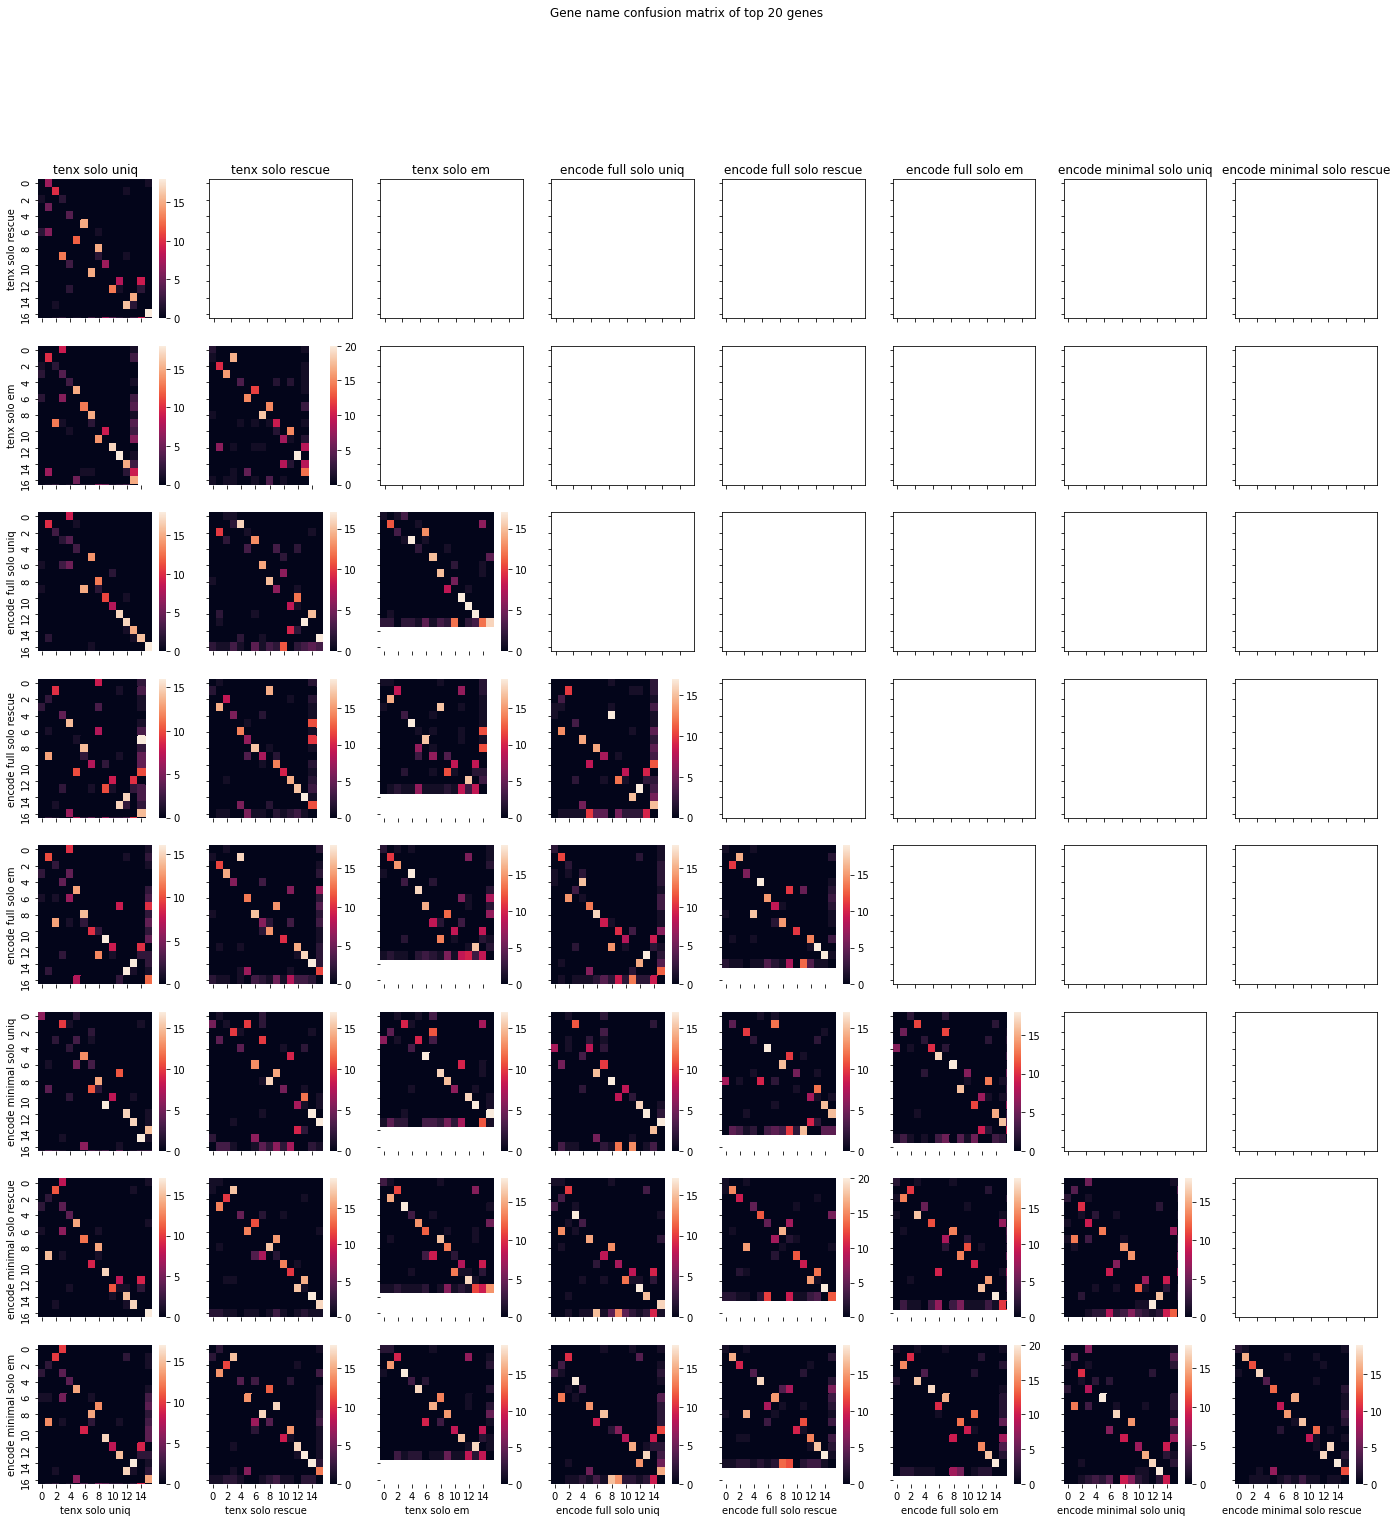

In [49]:
plot_algorithm_confusion(algorithm_top_gene_names, N=20)

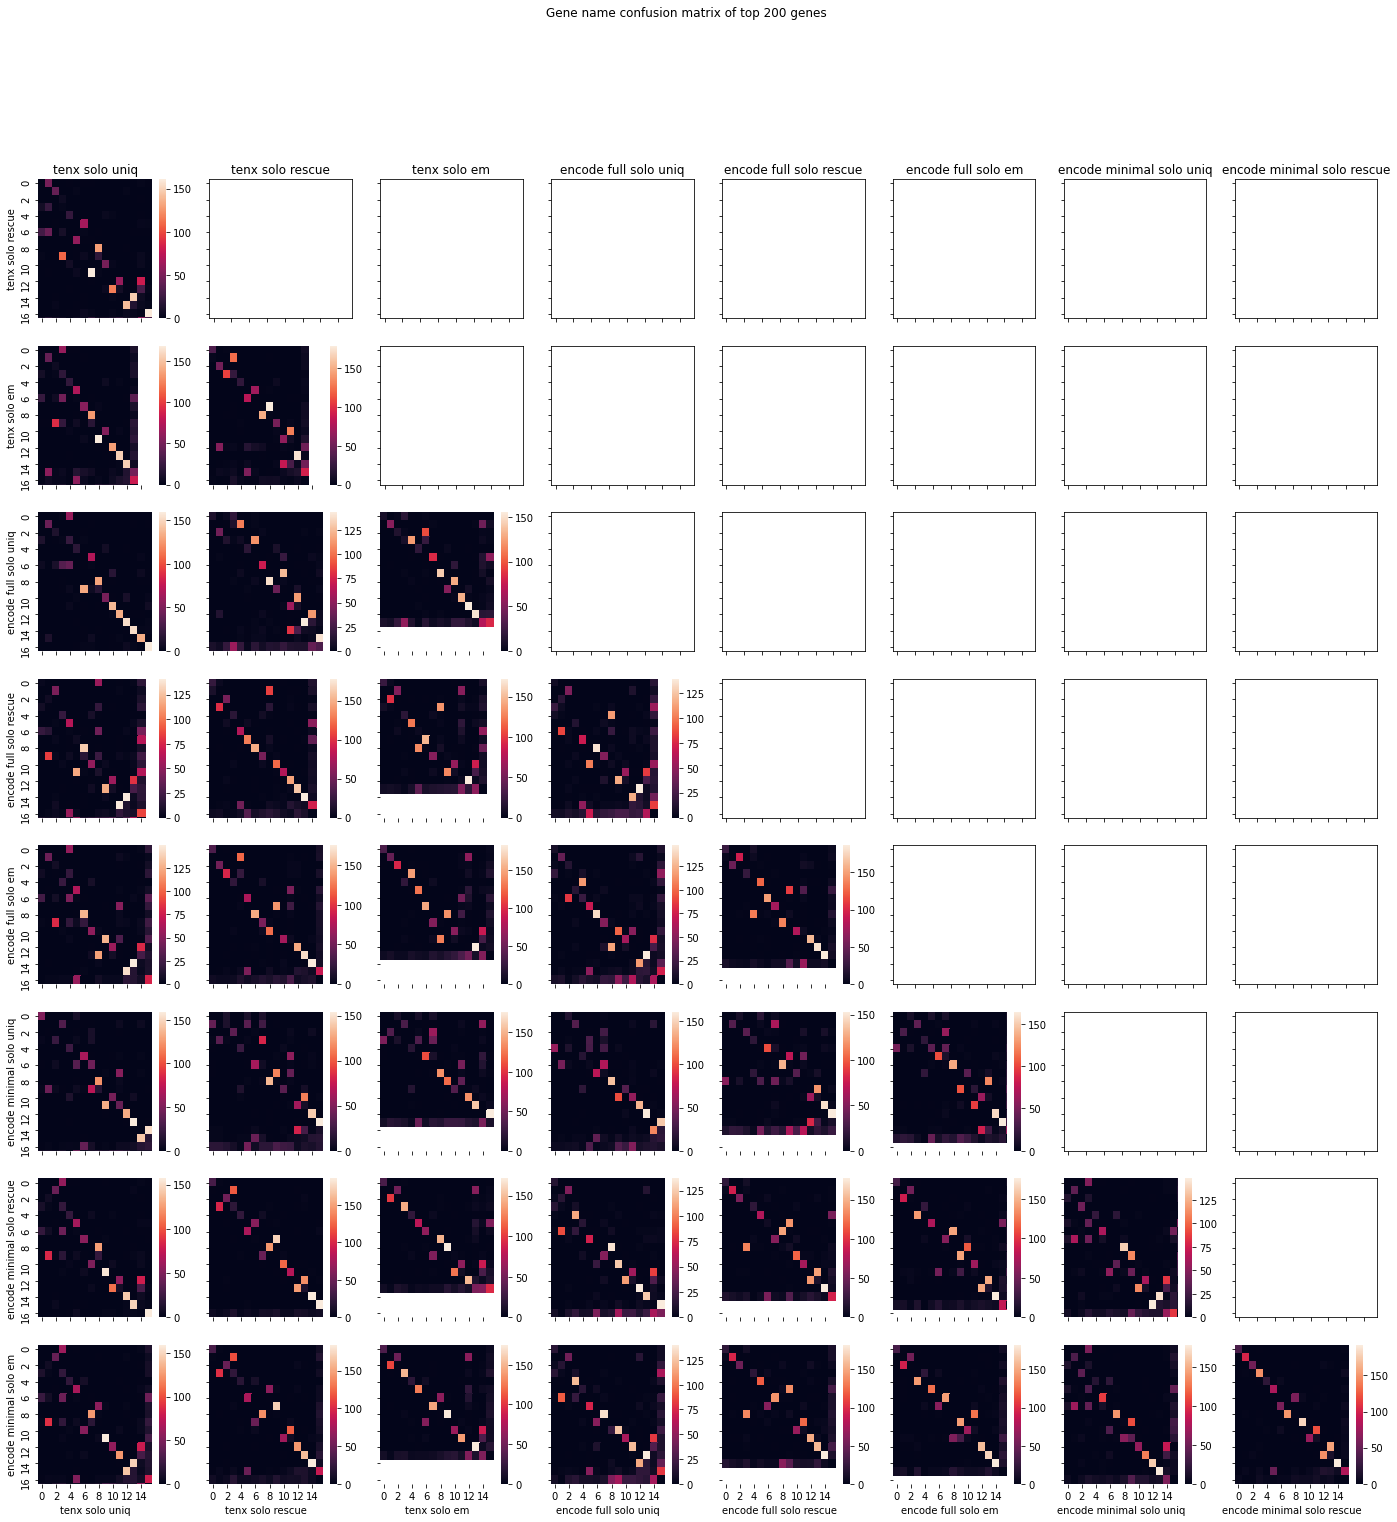

In [50]:
plot_algorithm_confusion(algorithm_top_gene_names, N=200)

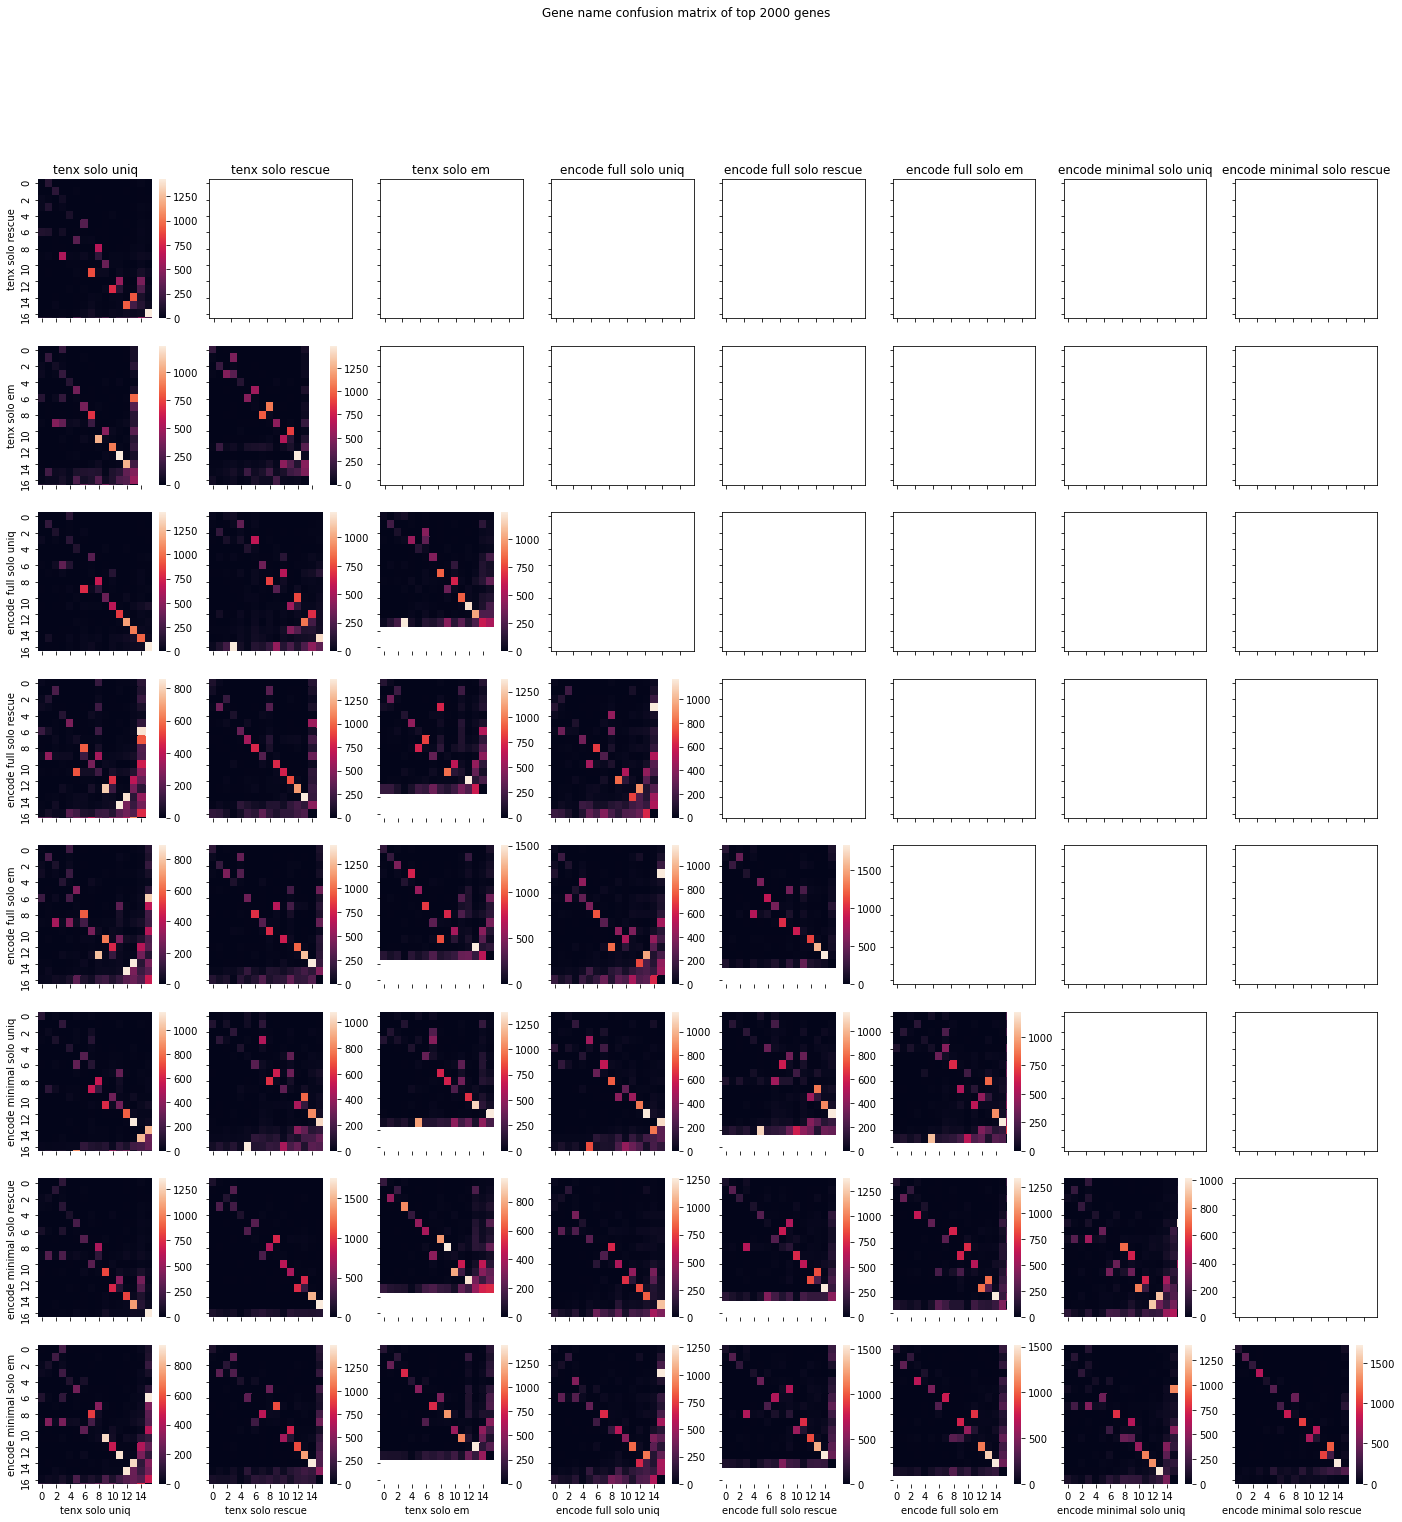

In [51]:
plot_algorithm_confusion(algorithm_top_gene_names, N=2000)

# Save h5 tables

In [52]:
for algorithm in algorithm_scanpy_filtered:
    run_dir, quantification, filtering, multiread = algorithm_roots[algorithm]
    h5ad_name = "{}_{}_{}.h5ad".format(quantification, "scanpy", multiread)
    algorithm_scanpy_filtered[algorithm].write_h5ad(run_dir / h5ad_name)